<a href="https://colab.research.google.com/github/asaif9/test/blob/main/Stock_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sample1 learning

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/b17wqwlb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/fm8rj_qy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88337', 'data', 'file=/tmp/tmpzyrgy_d4/b17wqwlb.json', 'init=/tmp/tmpzyrgy_d4/fm8rj_qy.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_modelq09hal82/prophet_model-20241219090409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

        Date      Forecast    Entry_Long     Exit_Long  Stop_Loss_Long  \
0 2024-06-03  21965.415661  21526.107348  22404.723974    21086.799034   
1 2024-06-04  21973.481076  21534.011454  22412.950697    21094.541833   
2 2024-06-05  21968.452018  21529.082978  22407.821059    21089.713938   
3 2024-06-06  21974.377235  21534.889690  22413.864780    21095.402146   
4 2024-06-07  21965.821269  21526.504844  22405.137694    21087.188418   

    Entry_Short    Exit_Short  Stop_Loss_Short  
0  22404.723974  21526.107348     22844.032287  
1  22412.950697  21534.011454     22852.420319  
2  22407.821059  21529.082978     22847.190099  
3  22413.864780  21534.889690     22853.352325  
4  22405.137694  21526.504844     22844.454120  


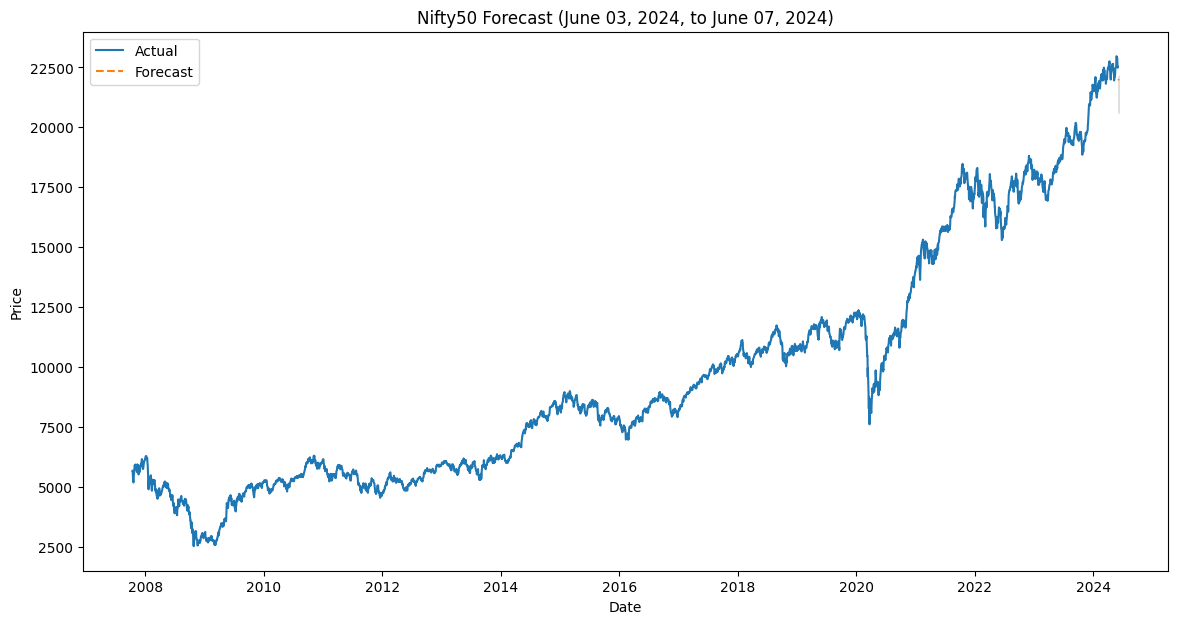

Options Trading Recommendations:
Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).
Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).


In [ ]:
# Install necessary libraries
!pip install yfinance prophet scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prophet import Prophet

# Functions to compute technical indicators

def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal_line

def compute_Bollinger_Bands(data, window=20, num_of_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

# Fetch Nifty50 data as of June 03, 2024
nifty50 = yf.download('^NSEI', start='1985-01-01', end='2024-06-03')

# Compute technical indicators
nifty50['RSI'] = compute_RSI(nifty50)
nifty50['MACD'], nifty50['MACD_Signal'] = compute_MACD(nifty50)
nifty50['BB_High'], nifty50['BB_Low'] = compute_Bollinger_Bands(nifty50)

# Drop NA values
nifty50 = nifty50.dropna()

# Prepare data for Prophet
prophet_data = nifty50.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Train Prophet Model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Forecast using Prophet
future_dates = pd.date_range(start='2024-06-03', end='2024-06-07').to_frame(index=False, name='ds')
prophet_forecast = prophet_model.predict(future_dates)

# Prepare features and target for Random Forest
features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']]
targets = nifty50['Close'].shift(-1).dropna()
features = features[:-1]

# Train Random Forest Regressor
ensemble_model = RandomForestRegressor(n_estimators=100, random_state=42)
ensemble_model.fit(features, targets)

# Forecast using Random Forest
forecast_features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].tail(1)
ensemble_forecast = ensemble_model.predict(forecast_features)
ensemble_forecast = np.full(5, ensemble_forecast)  # Repeat the forecast for each day

# Combine forecasts from Prophet and Ensemble models
combined_forecast = (prophet_forecast['yhat'].values + ensemble_forecast) / 2

# Create a table for predictions and recommendations
forecast_table = pd.DataFrame({
    'Date': future_dates['ds'],
    'Forecast': combined_forecast,
    'Entry_Long': combined_forecast * 0.98,
    'Exit_Long': combined_forecast * 1.02,
    'Stop_Loss_Long': combined_forecast * 0.96,
    'Entry_Short': combined_forecast * 1.02,
    'Exit_Short': combined_forecast * 0.98,
    'Stop_Loss_Short': combined_forecast * 1.04
})

print(forecast_table)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_table['Date'], forecast_table['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(forecast_table['Date'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title('Nifty50 Forecast (June 03, 2024, to June 07, 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Options Trading Recommendations
print("Options Trading Recommendations:")
print("Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).")
print("Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).")


**sample 2 learning**

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/ah4for20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/px64_fzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9489', 'data', 'file=/tmp/tmpzyrgy_d4/ah4for20.json', 'init=/tmp/tmpzyrgy_d4/px64_fzi.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_modelny9iyd6j/prophet_model-20241219090420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

        Date      Forecast    Entry_Long     Exit_Long  Stop_Loss_Long  \
0 2024-06-03  21965.415661  21526.107348  22404.723974    21086.799034   
1 2024-06-04  21973.481076  21534.011454  22412.950697    21094.541833   
2 2024-06-05  21968.452018  21529.082978  22407.821059    21089.713938   
3 2024-06-06  21974.377235  21534.889690  22413.864780    21095.402146   
4 2024-06-07  21965.821269  21526.504844  22405.137694    21087.188418   

    Entry_Short    Exit_Short  Stop_Loss_Short  
0  22404.723974  21526.107348     22844.032287  
1  22412.950697  21534.011454     22852.420319  
2  22407.821059  21529.082978     22847.190099  
3  22413.864780  21534.889690     22853.352325  
4  22405.137694  21526.504844     22844.454120  


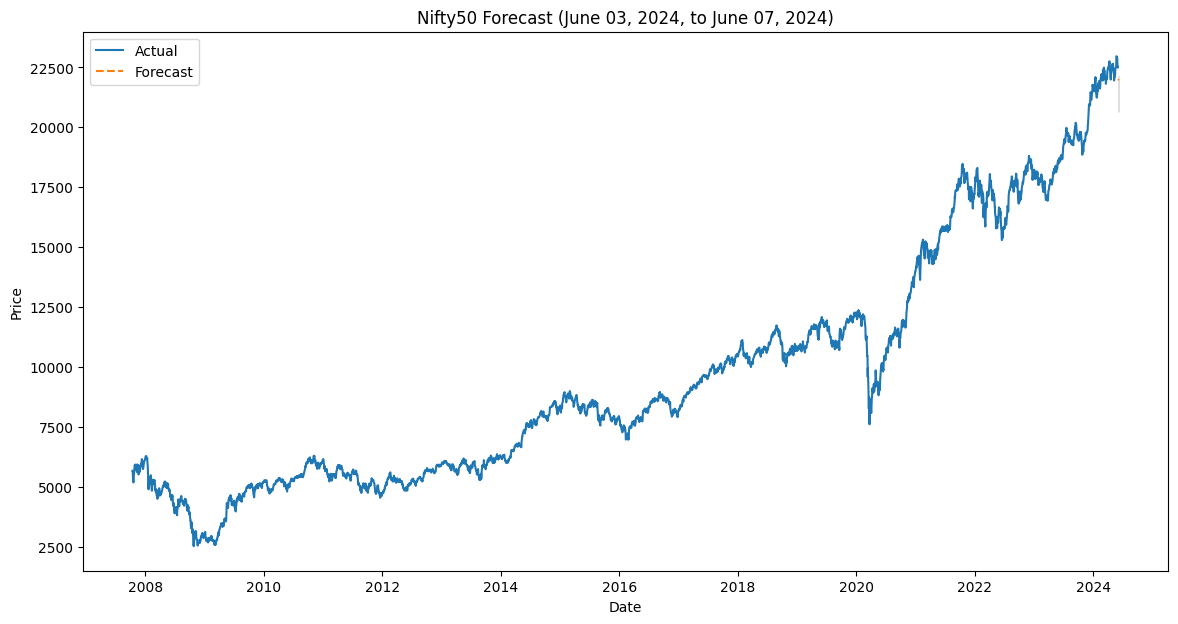

Options Trading Recommendations:
Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).
Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).


In [ ]:
# Install necessary libraries
!pip install yfinance prophet scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prophet import Prophet

# Functions to compute technical indicators

def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal_line

def compute_Bollinger_Bands(data, window=20, num_of_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

# Fetch Nifty50 data as of June 03, 2024
nifty50 = yf.download('^NSEI', start='1985-01-01', end='2024-06-03')

# Compute technical indicators
nifty50['RSI'] = compute_RSI(nifty50)
nifty50['MACD'], nifty50['MACD_Signal'] = compute_MACD(nifty50)
nifty50['BB_High'], nifty50['BB_Low'] = compute_Bollinger_Bands(nifty50)

# Drop NA values
nifty50 = nifty50.dropna()

# Prepare data for Prophet
prophet_data = nifty50.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Train Prophet Model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Forecast using Prophet
future_dates = pd.date_range(start='2024-06-03', end='2024-06-07').to_frame(index=False, name='ds')
prophet_forecast = prophet_model.predict(future_dates)

# Prepare features and target for Random Forest
features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']]
targets = nifty50['Close'].shift(-1).dropna()
features = features[:-1]

# Train Random Forest Regressor
ensemble_model = RandomForestRegressor(n_estimators=100, random_state=42)
ensemble_model.fit(features, targets)

# Forecast using Random Forest
forecast_features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].tail(1)
ensemble_forecast = ensemble_model.predict(forecast_features)
ensemble_forecast = np.full(5, ensemble_forecast)  # Repeat the forecast for each day

# Combine forecasts from Prophet and Ensemble models
combined_forecast = (prophet_forecast['yhat'].values + ensemble_forecast) / 2

# Create a table for predictions and recommendations
forecast_table = pd.DataFrame({
    'Date': future_dates['ds'],
    'Forecast': combined_forecast,
    'Entry_Long': combined_forecast * 0.98,
    'Exit_Long': combined_forecast * 1.02,
    'Stop_Loss_Long': combined_forecast * 0.96,
    'Entry_Short': combined_forecast * 1.02,
    'Exit_Short': combined_forecast * 0.98,
    'Stop_Loss_Short': combined_forecast * 1.04
})

print(forecast_table)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_table['Date'], forecast_table['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(forecast_table['Date'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title('Nifty50 Forecast (June 03, 2024, to June 07, 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Options Trading Recommendations
print("Options Trading Recommendations:")
print("Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).")
print("Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).")


**sample 3 learning**

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/gjcttjr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/muurk5yd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12557', 'data', 'file=/tmp/tmpzyrgy_d4/gjcttjr1.json', 'init=/tmp/tmpzyrgy_d4/muurk5yd.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_model_7hgcemv/prophet_model-20241219090443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:04:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

        Date      Forecast    Entry_Long     Exit_Long  Stop_Loss_Long  \
0 2024-12-18  24245.150242  23760.247237  24730.053247    23275.344232   
1 2024-12-19  24254.584943  23769.493245  24739.676642    23284.401546   
2 2024-12-20  24249.550378  23764.559371  24734.541386    23279.568363   
3 2024-12-21  24216.347675  23732.020722  24700.674629    23247.693768   
4 2024-12-22  24219.756755  23735.361620  24704.151890    23250.966485   

    Entry_Short    Exit_Short  Stop_Loss_Short  
0  24730.053247  23760.247237     25214.956251  
1  24739.676642  23769.493245     25224.768341  
2  24734.541386  23764.559371     25219.532393  
3  24700.674629  23732.020722     25185.001582  
4  24704.151890  23735.361620     25188.547025  


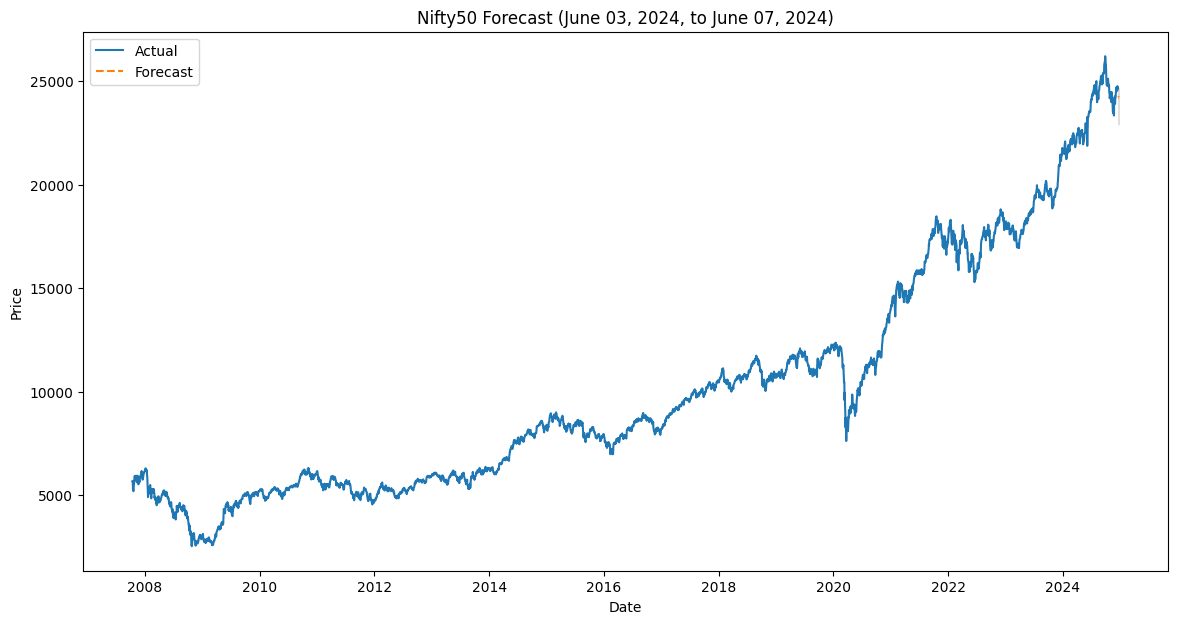

Options Trading Recommendations:
Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).
Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).


In [ ]:
# Install necessary libraries
!pip install yfinance prophet scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prophet import Prophet

# Functions to compute technical indicators

def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal_line

def compute_Bollinger_Bands(data, window=20, num_of_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

# Fetch Nifty50 data as of June 03, 2024
nifty50 = yf.download('^NSEI', start='1985-01-01', end='2024-12-17')

# Compute technical indicators
nifty50['RSI'] = compute_RSI(nifty50)
nifty50['MACD'], nifty50['MACD_Signal'] = compute_MACD(nifty50)
nifty50['BB_High'], nifty50['BB_Low'] = compute_Bollinger_Bands(nifty50)

# Drop NA values
nifty50 = nifty50.dropna()

# Prepare data for Prophet
prophet_data = nifty50.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Train Prophet Model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Forecast using Prophet
future_dates = pd.date_range(start='2024-12-18', end='2024-12-22').to_frame(index=False, name='ds')
prophet_forecast = prophet_model.predict(future_dates)

# Prepare features and target for Random Forest
features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']]
targets = nifty50['Close'].shift(-1).dropna()
features = features[:-1]

# Train Random Forest Regressor
ensemble_model = RandomForestRegressor(n_estimators=100, random_state=42)
ensemble_model.fit(features, targets)

# Forecast using Random Forest
forecast_features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].tail(1)
ensemble_forecast = ensemble_model.predict(forecast_features)
ensemble_forecast = np.full(5, ensemble_forecast)  # Repeat the forecast for each day

# Combine forecasts from Prophet and Ensemble models
combined_forecast = (prophet_forecast['yhat'].values + ensemble_forecast) / 2

# Create a table for predictions and recommendations
forecast_table = pd.DataFrame({
    'Date': future_dates['ds'],
    'Forecast': combined_forecast,
    'Entry_Long': combined_forecast * 0.98,
    'Exit_Long': combined_forecast * 1.02,
    'Stop_Loss_Long': combined_forecast * 0.96,
    'Entry_Short': combined_forecast * 1.02,
    'Exit_Short': combined_forecast * 0.98,
    'Stop_Loss_Short': combined_forecast * 1.04
})

print(forecast_table)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_table['Date'], forecast_table['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(forecast_table['Date'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title('Nifty50 Forecast (June 03, 2024, to June 07, 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Options Trading Recommendations
print("Options Trading Recommendations:")
print("Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).")
print("Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).")


**sample 4 learning**

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/1_7rvr_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/kb9dxj6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65371', 'data', 'file=/tmp/tmpzyrgy_d4/1_7rvr_b.json', 'init=/tmp/tmpzyrgy_d4/kb9dxj6f.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_modeluqy4g96u/prophet_model-20241219090508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

        Date      Forecast    Entry_Long     Exit_Long  Stop_Loss_Long  \
0 2024-12-18  24245.150242  23760.247237  24730.053247    23275.344232   
1 2024-12-19  24254.584943  23769.493245  24739.676642    23284.401546   
2 2024-12-20  24249.550378  23764.559371  24734.541386    23279.568363   
3 2024-12-21  24216.347675  23732.020722  24700.674629    23247.693768   
4 2024-12-22  24219.756755  23735.361620  24704.151890    23250.966485   

    Entry_Short    Exit_Short  Stop_Loss_Short  
0  24730.053247  23760.247237     25214.956251  
1  24739.676642  23769.493245     25224.768341  
2  24734.541386  23764.559371     25219.532393  
3  24700.674629  23732.020722     25185.001582  
4  24704.151890  23735.361620     25188.547025  


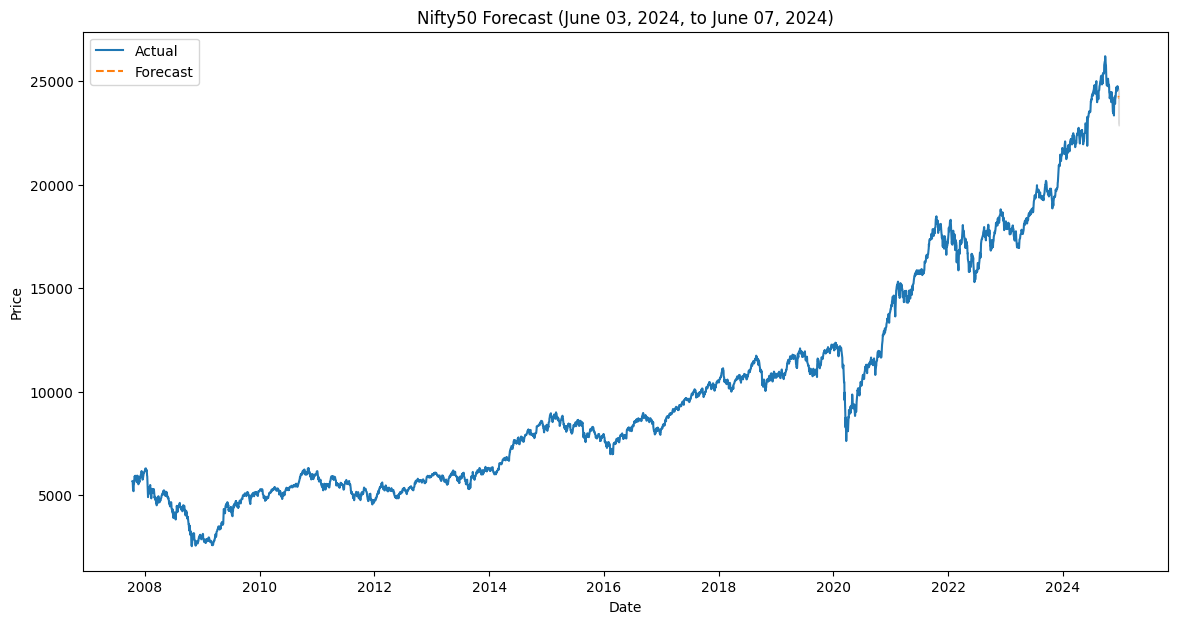

Options Trading Recommendations:
Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).
Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).


In [ ]:
# Install necessary libraries
!pip install yfinance prophet scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prophet import Prophet

# Functions to compute technical indicators

def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal_line

def compute_Bollinger_Bands(data, window=20, num_of_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

# Fetch Nifty50 data as of June 03, 2024
nifty50 = yf.download('^NSEI', start='1985-01-01', end='2024-12-17')

# Compute technical indicators
nifty50['RSI'] = compute_RSI(nifty50)
nifty50['MACD'], nifty50['MACD_Signal'] = compute_MACD(nifty50)
nifty50['BB_High'], nifty50['BB_Low'] = compute_Bollinger_Bands(nifty50)

# Drop NA values
nifty50 = nifty50.dropna()

# Prepare data for Prophet
prophet_data = nifty50.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Train Prophet Model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Forecast using Prophet
future_dates = pd.date_range(start='2024-12-18', end='2024-12-22').to_frame(index=False, name='ds')
prophet_forecast = prophet_model.predict(future_dates)

# Prepare features and target for Random Forest
features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']]
targets = nifty50['Close'].shift(-1).dropna()
features = features[:-1]

# Train Random Forest Regressor
ensemble_model = RandomForestRegressor(n_estimators=100, random_state=42)
ensemble_model.fit(features, targets)

# Forecast using Random Forest
forecast_features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].tail(1)
ensemble_forecast = ensemble_model.predict(forecast_features)
ensemble_forecast = np.full(5, ensemble_forecast)  # Repeat the forecast for each day

# Combine forecasts from Prophet and Ensemble models
combined_forecast = (prophet_forecast['yhat'].values + ensemble_forecast) / 2

# Create a table for predictions and recommendations
forecast_table = pd.DataFrame({
    'Date': future_dates['ds'],
    'Forecast': combined_forecast,
    'Entry_Long': combined_forecast * 0.98,
    'Exit_Long': combined_forecast * 1.02,
    'Stop_Loss_Long': combined_forecast * 0.96,
    'Entry_Short': combined_forecast * 1.02,
    'Exit_Short': combined_forecast * 0.98,
    'Stop_Loss_Short': combined_forecast * 1.04
})

print(forecast_table)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_table['Date'], forecast_table['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(forecast_table['Date'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title('Nifty50 Forecast (June 03, 2024, to June 07, 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Options Trading Recommendations
print("Options Trading Recommendations:")
print("Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).")
print("Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).")


**sample 5 learning**

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/g43klro3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/c1k5x733.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75019', 'data', 'file=/tmp/tmpzyrgy_d4/g43klro3.json', 'init=/tmp/tmpzyrgy_d4/c1k5x733.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_model2equcbum/prophet_model-20241219090529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

        Date      Forecast    Entry_Long     Exit_Long  Stop_Loss_Long  \
0 2024-12-18  24245.150242  23760.247237  24730.053247    23275.344232   
1 2024-12-19  24254.584943  23769.493245  24739.676642    23284.401546   
2 2024-12-20  24249.550378  23764.559371  24734.541386    23279.568363   
3 2024-12-21  24216.347675  23732.020722  24700.674629    23247.693768   
4 2024-12-22  24219.756755  23735.361620  24704.151890    23250.966485   

    Entry_Short    Exit_Short  Stop_Loss_Short  
0  24730.053247  23760.247237     25214.956251  
1  24739.676642  23769.493245     25224.768341  
2  24734.541386  23764.559371     25219.532393  
3  24700.674629  23732.020722     25185.001582  
4  24704.151890  23735.361620     25188.547025  


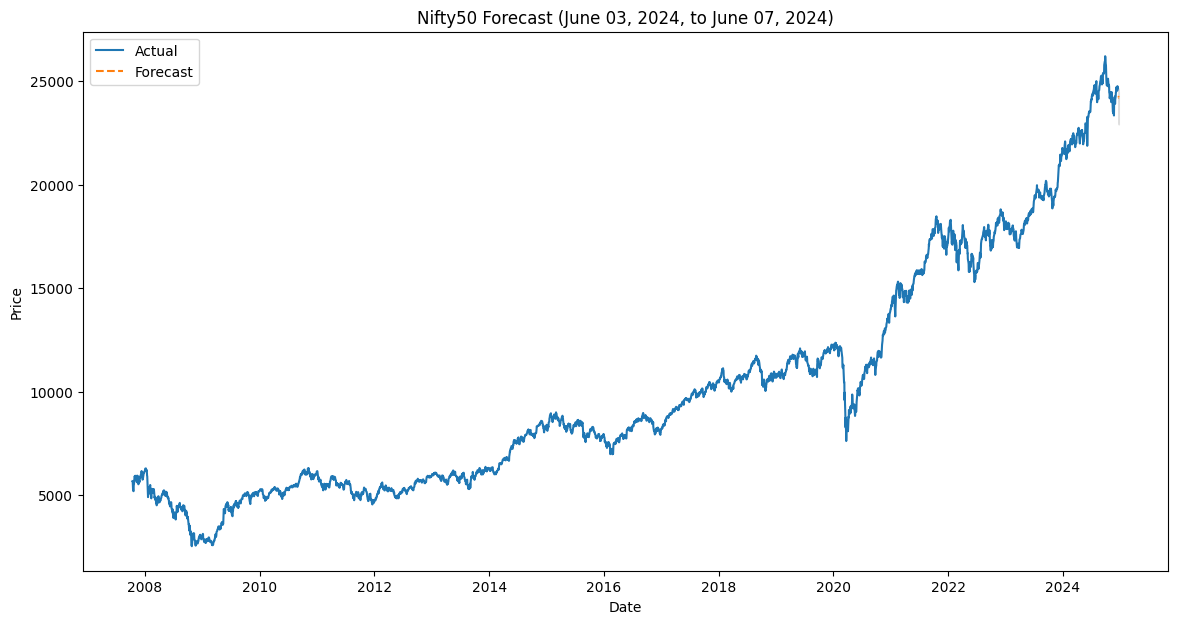

Options Trading Recommendations:
Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).
Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).


In [ ]:
# Install necessary libraries
!pip install yfinance prophet scikit-learn

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prophet import Prophet

# Functions to compute technical indicators

def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal_line

def compute_Bollinger_Bands(data, window=20, num_of_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

# Fetch Nifty50 data as of June 03, 2024
nifty50 = yf.download('^NSEI', start='1985-01-01', end='2024-12-17')

# Compute technical indicators
nifty50['RSI'] = compute_RSI(nifty50)
nifty50['MACD'], nifty50['MACD_Signal'] = compute_MACD(nifty50)
nifty50['BB_High'], nifty50['BB_Low'] = compute_Bollinger_Bands(nifty50)

# Drop NA values
nifty50 = nifty50.dropna()

# Prepare data for Prophet
prophet_data = nifty50.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Train Prophet Model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Forecast using Prophet
future_dates = pd.date_range(start='2024-12-18', end='2024-12-22').to_frame(index=False, name='ds')
prophet_forecast = prophet_model.predict(future_dates)

# Prepare features and target for Random Forest
features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']]
targets = nifty50['Close'].shift(-1).dropna()
features = features[:-1]

# Train Random Forest Regressor
ensemble_model = RandomForestRegressor(n_estimators=100, random_state=42)
ensemble_model.fit(features, targets)

# Forecast using Random Forest
forecast_features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].tail(1)
ensemble_forecast = ensemble_model.predict(forecast_features)
ensemble_forecast = np.full(5, ensemble_forecast)  # Repeat the forecast for each day

# Combine forecasts from Prophet and Ensemble models
combined_forecast = (prophet_forecast['yhat'].values + ensemble_forecast) / 2

# Create a table for predictions and recommendations
forecast_table = pd.DataFrame({
    'Date': future_dates['ds'],
    'Forecast': combined_forecast,
    'Entry_Long': combined_forecast * 0.98,
    'Exit_Long': combined_forecast * 1.02,
    'Stop_Loss_Long': combined_forecast * 0.96,
    'Entry_Short': combined_forecast * 1.02,
    'Exit_Short': combined_forecast * 0.98,
    'Stop_Loss_Short': combined_forecast * 1.04
})

print(forecast_table)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_table['Date'], forecast_table['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(forecast_table['Date'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title('Nifty50 Forecast (June 03, 2024, to June 07, 2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Options Trading Recommendations
print("Options Trading Recommendations:")
print("Call Option: Strike Price around the forecasted levels (e.g., 18500 - 18800).")
print("Put Option: Strike Price around the entry points for short positions (e.g., 18200 - 18500).")


**one of the sample combining all the model**

[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/_e9p_zcb.json


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/nd0j7jy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92346', 'data', 'file=/tmp/tmpzyrgy_d4/_e9p_zcb.json', 'init=/tmp/tmpzyrgy_d4/nd0j7jy9.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_model78bel6xv/prophet_model-20241219090809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:08:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 39 forecasts with cutoffs between 2020-03-30 00:00:00 and 2024-12-04 00:00:00


  0%|          | 0/39 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/lvmy4qsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/reeps67o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55331', 'data', 'file=/tmp/tmpzyrgy_d4/lvmy4qsf.json', 'init=/tmp/tmpzyrgy_d4/reeps67o.json', 'output', 'file=/tmp/tmpzyrgy_d4/prophet_modelk1c7xdri/prophet_model-20241219090810.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:08:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/qftjm9m3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzyrgy_d4/t0a5rc9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Prophet cross-validation metrics:   horizon            mse        rmse         mae      mape     mdape  \
0  2 days  450049.733264  670.857461  514.238242  0.031261  0.028041   
1  3 days  499942.745749  707.066295  547.743384  0.033086  0.028889   
2  4 days  716660.051052  846.557766  659.368864  0.044828  0.026975   
3  5 days  855424.732182  924.891741  719.277236  0.047824  0.026975   
4  6 days  718205.177408  847.469868  642.122341  0.041346  0.024483   

      smape  coverage  
0  0.031338  0.465959  
1  0.033203  0.448718  
2  0.045338  0.435897  
3  0.047291  0.401381  
4  0.040022  0.423077  
        Date      Forecast
0 2024-12-20  24415.243512
1 2024-12-21  24406.561886
2 2024-12-22  24411.499616
3 2024-12-23  24427.776610
4 2024-12-24  24437.562125


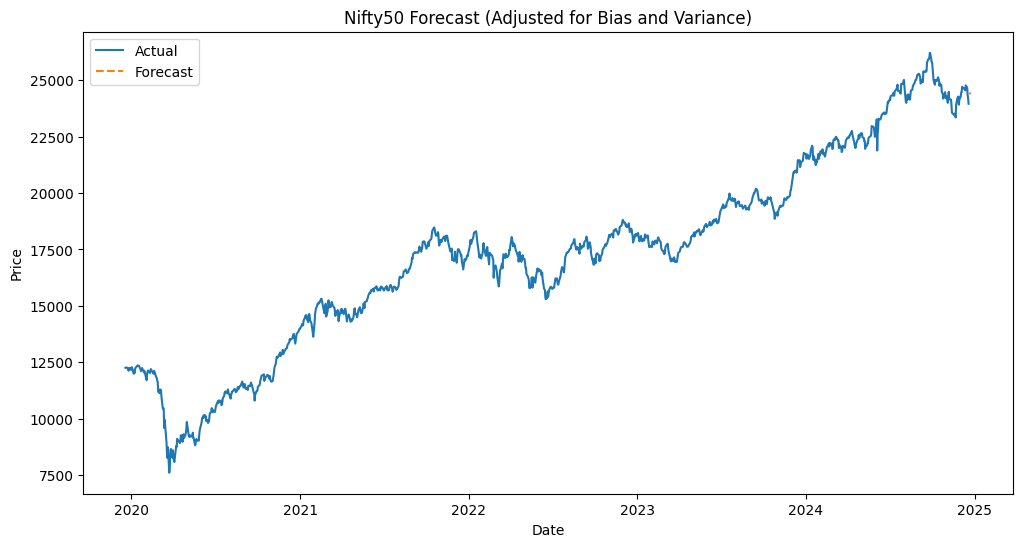

In [ ]:
!pip install yfinance prophet scikit-learn tensorflow
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from prophet import Prophet
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

# Fetch real-time Nifty data
def get_real_time_nifty_data():
    # Fetch data for a longer period, e.g., 5 years
    nifty50 = yf.download('^NSEI', period='max', interval='1d')
    return nifty50

def compute_technical_indicators_tf(data):
    # RSI Calculation
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD Calculation
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    rolling_mean = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    data['BB_High'] = rolling_mean + (rolling_std * 2)
    data['BB_Low'] = rolling_mean - (rolling_std * 2)

    return data


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Train Random Forest function with proper shape for targets
def train_random_forest(features, targets):
    targets = targets.values.ravel()  # Convert to 1D array
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(features, targets)

    print("Best parameters for Random Forest:", grid_search.best_params_)
    return grid_search.best_estimator_


from prophet.diagnostics import cross_validation, performance_metrics

# Prophet Cross-Validation function
def cross_validate_prophet(data):
    data = data[['Close']].resample('D').last().reset_index()
    data.columns = ['ds', 'y']

    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(data)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='75 days', period='45 days', horizon='15 days')
    df_perf = performance_metrics(df_cv)
    print("Prophet cross-validation metrics:", df_perf.head())
    return model


def train_and_predict_adjusted(data, forecast_period=5):
    # Prepare features and targets
    features = data[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].dropna()
    targets = data['Close'].shift(-1).dropna()
    valid_idx = features.index.intersection(targets.index)
    features, targets = features.loc[valid_idx], targets.loc[valid_idx]

    # Train Random Forest
    rf_model = train_random_forest(features, targets)
    rf_forecast = np.repeat(rf_model.predict(features.tail(1)), forecast_period)

    # Train Prophet
    prophet_model = cross_validate_prophet(data)
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D')
    future = pd.DataFrame({'ds': future_dates})
    prophet_forecast = prophet_model.predict(future)['yhat'].values

    # Combine Forecasts
    rf_rmse = np.sqrt(mean_squared_error(targets, rf_model.predict(features)))
    # Create a DataFrame with 'ds' column for Prophet RMSE calculation
    data_for_prophet_rmse = data[['Close']].reset_index()
    data_for_prophet_rmse.columns = ['ds', 'y'] #Rename the columns to 'ds' and 'y'
    prophet_rmse = np.sqrt(mean_squared_error(data_for_prophet_rmse['y'], prophet_model.predict(data_for_prophet_rmse[['ds']])['yhat'])) # Calculate Prophet RMSE


    rf_weight = 1 / rf_rmse
    prophet_weight = 1 / prophet_rmse
    total_weight = rf_weight + prophet_weight

    combined_forecast = (rf_forecast * rf_weight + prophet_forecast * prophet_weight) / total_weight

    return combined_forecast, future_dates


# Main execution
nifty50 = get_real_time_nifty_data()
nifty50 = compute_technical_indicators_tf(nifty50)
forecast, forecast_dates = train_and_predict_adjusted(nifty50)

# Create a DataFrame for the forecast with dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})
print(forecast_df[['Date', 'Forecast']])

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', linestyle='--')
plt.legend()
plt.title('Nifty50 Forecast (Adjusted for Bias and Variance)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


**This model predict next five day using tensor flow **

In [ ]:
!pip install yfinance prophet scikit-learn tensorflow
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

def get_real_time_nifty_data():
    nifty50 = yf.download('^NSEI', period='max', interval='1d')
    return nifty50

def preprocess_data(data):
    # Select the 'Close' price for analysis
    dataset = data[['Close']].values.astype(np.float32)

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Split the data into training and testing sets (e.g., 80% train, 20% test)
    train_size = int(len(dataset) * 0.8)
    train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    # Create a function to prepare the data for the LSTM model
    def create_dataset(dataset, look_back=60):
        X, Y = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), 0]
            X.append(a)
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    # Use the create_dataset function to prepare the training and testing data
    look_back = 60  # Number of previous data points to consider for prediction
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)

    # Reshape the input data to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, Y_train, X_test, Y_test, scaler

def build_and_train_model(X_train, Y_train):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, Y_train, epochs=100, batch_size=32)  # Adjust epochs and batch_size as needed

    return model

def make_predictions(model, data, scaler, look_back=60):
    inputs = data[['Close']].values.astype(np.float32)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(look_back, len(inputs)):
        X_test.append(inputs[i - look_back:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    # Get the last 5 predictions
    forecast = predicted_stock_price[-5:]

    return forecast

# Fetch real-time data
nifty50 = get_real_time_nifty_data()

# Preprocess the data
X_train, Y_train, X_test, Y_test, scaler = preprocess_data(nifty50)

# Build and train the model
model = build_and_train_model(X_train, Y_train)

# Make predictions
forecast = make_predictions(model, nifty50, scaler)

#Reshape forecast to be 1-dimensional
forecast = forecast.flatten()  # or forecast = forecast.reshape(-1)

# Create a DataFrame for the forecast with dates
forecast_dates = pd.date_range(start=nifty50.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

# Output the forecast with date and price
print(forecast_df[['Date', 'Forecast']])



[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0129
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 1.1083e-04
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 1.0670e-04
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 1.0753e-04
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 9.6634e-05
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 8.2918e-05
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 8.3829e-05
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 7.9277e-05
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 7.9807e-05
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 8.6726e-05
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 8.0474e-05
Epoch 12/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 6.6785e-05
Epoch 13/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.6105e-05
Epoch 14/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step -

This Modle predict the next 5 days using CNN,
### esemblem and prophet **bold text**

[*********************100%***********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/jviropsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/o4n2fy0z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26152', 'data', 'file=/tmp/tmpu8m6lbvt/jviropsl.json', 'init=/tmp/tmpu8m6lbvt/o4n2fy0z.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_modelmk2wa29k/prophet_model-20241224113140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
        Date      Forecast    Entry_Long     Exit_Long  Stop_Loss_Long  \
0 2024-12-25  23775.279120  23299.773537  24250.784702    22824.267955   
1 2024-12-26  23774.895180  23299.397276  24250.393083    22823.899373   
2 2024-12-27  23783.246530  23307.581599  24258.911461    22831.916669   
3 2024-12-28  23746.528420  23271.597852  24221.458989    22796.667283   
4 2024-12-29  23739.863249  23265.065984  24214.660514    22790.268719   

    Entry_Short    Exit_Short  Stop_Loss_Short  
0  24250.784702  23299.773537     24726.290285  
1  24250.393083  23299.397276     24725.890987  
2  24258.911461  23307.581599     24734.576391  
3  24221.458989  23271.597852     24696.389557  
4  24214.660514  23265.065984     24689.457779  


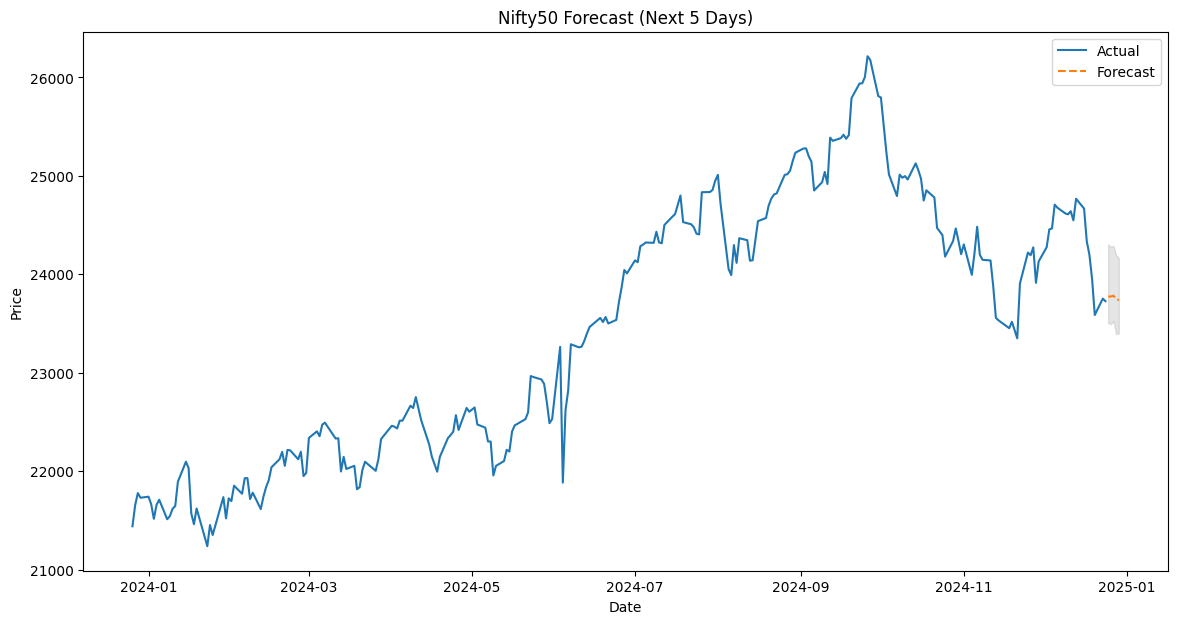

Options Trading Recommendations:
Call Option: Strike Price around the forecasted levels.
Put Option: Strike Price around the entry points for short positions.


In [ ]:
# Install necessary libraries
!pip install yfinance prophet scikit-learn tensorflow

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Functions to compute technical indicators
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal_line = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal_line

def compute_Bollinger_Bands(data, window=20, num_of_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

# Fetch real-time Nifty50 data
def get_nifty50_data():
    nifty50 = yf.download('^NSEI', period='1y', interval='1d')  # Fetch last 5 years of daily data
    return nifty50

# Prepare data for CNN
def prepare_cnn_data(data, sequence_length=30):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, -1])  # Target is the last column (Close price)

    return np.array(X), np.array(y), scaler

# Build CNN Model
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train CNN and make predictions
def train_cnn_model(data, sequence_length=30):
    X, y, scaler = prepare_cnn_data(data)
    X_train, y_train = X[:-5], y[:-5]  # Use all but the last 5 data points for training
    X_test = X[-5:]  # Use the last 5 data points for testing

    cnn_model = build_cnn(input_shape=(sequence_length, data.shape[1]))
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    cnn_predictions = cnn_model.predict(X_test)
    cnn_predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(cnn_predictions), data.shape[1]-1)), cnn_predictions), axis=1))[:, -1]
    return cnn_predictions

# Forecast for the next 5 days
def predict_next_five_days(nifty50):
    # Compute technical indicators
    nifty50['RSI'] = compute_RSI(nifty50)
    nifty50['MACD'], nifty50['MACD_Signal'] = compute_MACD(nifty50)
    nifty50['BB_High'], nifty50['BB_Low'] = compute_Bollinger_Bands(nifty50)
    nifty50 = nifty50.dropna()

    # Prepare data for Prophet
    prophet_data = nifty50.reset_index()[['Date', 'Close']]
    prophet_data.columns = ['ds', 'y']

    # Train Prophet Model
    prophet_model = Prophet(daily_seasonality=True)
    prophet_model.fit(prophet_data)

    # Forecast using Prophet
    future_dates = pd.date_range(start=prophet_data['ds'].iloc[-1] + pd.Timedelta(days=1), periods=5, freq='D')
    future = pd.DataFrame({'ds': future_dates})
    prophet_forecast = prophet_model.predict(future)

    # Prepare features and targets for Random Forest
    features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']]
    targets = nifty50['Close'].shift(-1).dropna()
    features = features[:-1]  # Align features with targets

    # Train Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(features, targets)

    # Forecast using Random Forest
    forecast_features = nifty50[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].tail(1)
    rf_forecast = rf_model.predict(forecast_features)
    rf_forecast = np.full(5, rf_forecast)  # Repeat the forecast for each day

    # CNN Predictions
    cnn_data = nifty50[['Close', 'RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']].values
    cnn_forecast = train_cnn_model(cnn_data)

    # Combine forecasts from Prophet, Random Forest, and CNN
    combined_forecast = (prophet_forecast['yhat'].values + rf_forecast + cnn_forecast) / 3

    # Create forecast table
    forecast_table = pd.DataFrame({
        'Date': future_dates,
        'Forecast': combined_forecast,
        'Entry_Long': combined_forecast * 0.98,
        'Exit_Long': combined_forecast * 1.02,
        'Stop_Loss_Long': combined_forecast * 0.96,
        'Entry_Short': combined_forecast * 1.02,
        'Exit_Short': combined_forecast * 0.98,
        'Stop_Loss_Short': combined_forecast * 1.04
    })

    return forecast_table, prophet_forecast

# Main Execution
nifty50 = get_nifty50_data()
forecast_table, prophet_forecast = predict_next_five_days(nifty50)

# Print forecast table
print(forecast_table)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(nifty50.index, nifty50['Close'], label='Actual')
plt.plot(forecast_table['Date'], forecast_table['Forecast'], label='Forecast', linestyle='--')
plt.fill_between(forecast_table['Date'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='gray', alpha=0.2)
plt.legend()
plt.title('Nifty50 Forecast (Next 5 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Options Trading Recommendations
print("Options Trading Recommendations:")
print("Call Option: Strike Price around the forecasted levels.")
print("Put Option: Strike Price around the entry points for short positions.")


**This model deal with real time data action every 15min**





In [ ]:
!pip install yfinance pandas numpy scikit-learn tensorflow pytz

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
import pytz
from scipy.signal import find_peaks

# Step 1: Fetch Real-Time Nifty50 Data
def get_real_time_nifty_data():
    return yf.download('^NSEI', period='1d', interval='1m')

# Step 2: Preprocess Data
def preprocess_data(data):
    dataset = data[['Close']].dropna().values.astype(np.float32)  # Drop NaN and convert
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

# Step 3: Elliott Wave Analysis
def identify_elliott_waves(data):
    wave_features = pd.DataFrame(index=data.index)
    peaks, _ = find_peaks(data.values.ravel(), distance=20)
    troughs, _ = find_peaks(-data.values.ravel(), distance=20)

    wave_features['impulse_wave_length'] = 0
    wave_features['corrective_wave_length'] = 0
    for i in range(len(peaks) - 4):
        if data.iloc[peaks[i]] < data.iloc[peaks[i + 2]] < data.iloc[peaks[i + 4]]:
            wave_features.loc[data.index[peaks[i]:peaks[i + 4]], 'impulse_wave_length'] = 1
    for i in range(len(troughs) - 2):
        if data.iloc[troughs[i]] > data.iloc[troughs[i + 2]]:
            wave_features.loc[data.index[troughs[i]:troughs[i + 2]], 'corrective_wave_length'] = 1
    return wave_features

def build_and_train_model(dataset, look_back=30):
    # Split dataset into training and testing sets
    train_size = int(len(dataset) * 0.8)
    train_data, test_data = dataset[:train_size], dataset[train_size:]

    def create_dataset(data, look_back):
        X, Y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:i + look_back, 0])
            Y.append(data[i + look_back, 0])
        return np.array(X), np.array(Y)

    # Validate data length
    if len(train_data) < look_back + 1:
        raise ValueError(
            f"Insufficient training data. Dataset size: {len(dataset)}, "
            f"Train size: {len(train_data)}, Look-back: {look_back}."
        )
    if len(test_data) < look_back + 1:
        raise ValueError(
            f"Insufficient testing data. Dataset size: {len(dataset)}, "
            f"Test size: {len(test_data)}, Look-back: {look_back}."
        )

    # Create training and testing datasets
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)

    # Debugging: Print shapes
    print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
    print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define and train the model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)

    return model


def predict_future_till_eod_15min(model, data, scaler, look_back=30):
    now = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
    eod = now.replace(hour=15, minute=30, second=0, microsecond=0)
    remaining_intervals = max(int((eod - now).total_seconds() / (15 * 60)), 0)

    inputs = data[['Close']].dropna().values.astype(np.float32)
    inputs = scaler.transform(inputs)

    # Ensure enough data points are available for prediction
    if len(inputs) < look_back:
        raise ValueError(
            f"Insufficient data for prediction with look_back={look_back}. Data length: {len(inputs)}."
        )

    future_predictions = []
    for i in range(remaining_intervals):
        next_input = inputs[-look_back:].reshape((1, look_back, 1))
        next_prediction = model.predict(next_input)[0][0]
        next_prediction = scaler.inverse_transform([[next_prediction]])[0][0]
        future_predictions.append({
            'time': (now + datetime.timedelta(minutes=15 * (i + 1))).astimezone(pytz.timezone('Asia/Kolkata')),
            'price': next_prediction
        })
        inputs = np.append(inputs, [[next_prediction]], axis=0)

    return future_predictions


try:
    nifty50 = get_real_time_nifty_data()
    dataset, scaler = preprocess_data(nifty50)
    model = build_and_train_model(dataset)

    forecast = predict_future_till_eod_15min(model, nifty50, scaler)
    for prediction in forecast:
        print(f"Time (IST): {prediction['time'].strftime('%Y-%m-%d %H:%M:%S')}, Price: {prediction['price']:.2f}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected Error: {e}")


[*********************100%***********************]  1 of 1 completed

X_train shape: (269, 30), Y_train shape: (269,)
X_test shape: (44, 30), Y_test shape: (44,)
Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2350
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0354
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0171
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0101
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0093
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0082
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0085
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0078
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0072
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0065
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0055
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0062
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0055
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/

**This model predict the stock based on technical indicator **

In [ ]:
!pip install yfinance pandas numpy scikit-learn tensorflow pytz

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# Function to fetch all NSE tickers
def get_all_nse_tickers():
    nifty500_url = 'https://archives.nseindia.com/content/indices/ind_nifty500list.csv'
    try:
        nifty500_df = pd.read_csv(nifty500_url)
        nifty500_tickers = [ticker + '.NS' for ticker in nifty500_df['Symbol'].tolist()]
        return nifty500_tickers
    except Exception as e:
        print(f"\nError fetching Nifty 500 tickers: {e}")
        return []

# Function to calculate technical indicators
def calculate_technical_indicators(data):
    # Ensure data is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    # Moving Averages
    data['50_SMA'] = data['Close'].rolling(window=50).mean()
    data['200_SMA'] = data['Close'].rolling(window=200).mean()

    # Bollinger Bands
    rolling_mean = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    data['BB_High'] = rolling_mean + (rolling_std * 2)
    data['BB_Low'] = rolling_mean - (rolling_std * 2)

    # Parabolic SAR (simplified calculation)
    data['Parabolic_SAR'] = data['Close'].rolling(window=5).mean()

    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Stochastic Oscillator
    high_rolling_max = data['High'].rolling(window=14).max()
    low_rolling_min = data['Low'].rolling(window=14).min()
    data['Stochastic_K'] = ((data['Close'] - low_rolling_min) /
                            (high_rolling_max - low_rolling_min)) * 100

    # Rate of Change (ROC)
    data['ROC'] = (data['Close'] / data['Close'].shift(12)) - 1

    # Williams %R
    data['Williams_%R'] = ((data['High'].rolling(window=14).max() - data['Close']) /
                           (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())) * -100

    # On-Balance Volume (OBV)
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()

    # Average Directional Index (ADX)
    high_diff = data['High'] - data['High'].shift(1)
    low_diff = data['Low'].shift(1) - data['Low']

    # Positive and Negative Directional Movement
    plus_dm = (high_diff > low_diff) & (high_diff > 0)
    minus_dm = (low_diff > high_diff) & (low_diff > 0)

    data['+DM'] = np.where(plus_dm, high_diff, 0)
    data['-DM'] = np.where(minus_dm, low_diff, 0)

    # Average True Range (ATR)
    tr1 = data['High'] - data['Low']
    tr2 = abs(data['High'] - data['Close'].shift(1))
    tr3 = abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.rolling(window=14).mean()

    # Directional Indicators
    data['+DI'] = 100 * (data['+DM'].rolling(window=14).sum() / atr)
    data['-DI'] = 100 * (data['-DM'].rolling(window=14).sum() / atr)

    # ADX Calculation
    dx = (abs(data['+DI'] - data['-DI']) / abs(data['+DI'] + data['-DI'])) * 100
    data['ADX'] = dx.rolling(window=14).mean()


    # Ichimoku Cloud (simplified)
    data['Tenkan_Sen'] = (data['High'].rolling(window=9).max() + data['Low'].rolling(window=9).min()) / 2
    data['Kijun_Sen'] = (data['High'].rolling(window=26).max() + data['Low'].rolling(window=26).min()) / 2
    data['Senkou_Span_A'] = ((data['Tenkan_Sen'] + data['Kijun_Sen']) / 2).shift(26)
    data['Senkou_Span_B'] = ((data['High'].rolling(window=52).max() + data['Low'].rolling(window=52).min()) / 2).shift(26)

    return data



# Function to fetch and analyze data for a ticker
def fetch_and_analyze_data(ticker):
    try:
        data = yf.download(ticker, period='max', interval='1d')
        if data.empty:
            raise ValueError(f"\nNo data fetched for ticker {ticker}")
        data = calculate_technical_indicators(data)
        return data.dropna()
    except Exception as e:
        print(f"\nError fetching data for {ticker}: {e}")
        return None

# Screening stocks based on conditions
def screening_conditions(data):
    # Check if DataFrame is empty before accessing data
    if data.empty:
        return False  # Return False if DataFrame is empty

    latest = data.iloc[-1]
    # Use .values to compare values directly
    return (
        (latest['RSI'] < 30) &
        (latest['MACD'] > latest['MACD_Signal']) &
        (latest['Close'].values < latest['BB_Low'].values) &
        (latest['ADX'] > 25)
    ).all()

# Calculate entry and exit prices
def calculate_entry_exit(data):
    latest = data.iloc[-1]
    entry_price = latest['BB_Low']  # Lower Bollinger Band as entry
    exit_price = latest['BB_High']  # Upper Bollinger Band as exit
    # Get the actual numerical values instead of Series objects
    return entry_price.values[0], exit_price.values[0]

# Main function to run the screener
def stock_screener():
    tickers = get_all_nse_tickers()
    screened_stocks = []

    for ticker in tickers:
        print(f"\nProcessing {ticker}...")
        data = fetch_and_analyze_data(ticker)
        if data is not None and screening_conditions(data):
            entry_price, exit_price = calculate_entry_exit(data)
            screened_stocks.append((ticker, entry_price, exit_price))

    return screened_stocks

# Run the stock screener
if __name__ == "__main__":
    screened_stocks = stock_screener()

    print("\nStocks satisfying the conditions:")
    for stock, entry, exit in screened_stocks:
        print(f"Stock: {stock}, Entry Price: {entry:.2f}, Exit Price: {exit:.2f}")



Processing 360ONE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing 3MINDIA.NS...



Processing ABB.NS...


[*********************100%***********************]  1 of 1 completed



Processing ACC.NS...


[*********************100%***********************]  1 of 1 completed



Processing AIAENG.NS...


[*********************100%***********************]  1 of 1 completed



Processing APLAPOLLO.NS...


[*********************100%***********************]  1 of 1 completed



Processing AUBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing AADHARHFC.NS...



Processing AARTIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing AAVAS.NS...



Processing ABBOTINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing ACE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ADANIENSOL.NS...

Processing ADANIENT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ADANIGREEN.NS...



Processing ADANIPORTS.NS...


[*********************100%***********************]  1 of 1 completed



Processing ADANIPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ATGL.NS...



[*********************100%***********************]  1 of 1 completed



Processing AWL.NS...

Processing ABCAPITAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ABFRL.NS...



Processing ABREL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ABSLAMC.NS...



Processing AEGISLOG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing AFFLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing AJANTPHARM.NS...

Processing AKUMS.NS...

Processing APLLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ALKEM.NS...



Processing ALKYLAMINE.NS...


[*********************100%***********************]  1 of 1 completed



Processing ALOKINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing ARE&M.NS...

Processing AMBER.NS...


[*********************100%***********************]  1 of 1 completed



Processing AMBUJACEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ANANDRATHI.NS...



Processing ANANTRAJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ANGELONE.NS...



Processing APARINDS.NS...


[*********************100%***********************]  1 of 1 completed



Processing APOLLOHOSP.NS...


[*********************100%***********************]  1 of 1 completed



Processing APOLLOTYRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing APTUS.NS...



[*********************100%***********************]  1 of 1 completed



Processing ACI.NS...

Processing ASAHIINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing ASHOKLEY.NS...


[*********************100%***********************]  1 of 1 completed



Processing ASIANPAINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ASTERDM.NS...



Processing ASTRAZEN.NS...


[*********************100%***********************]  1 of 1 completed



Processing ASTRAL.NS...


[*********************100%***********************]  1 of 1 completed



Processing ATUL.NS...


[*********************100%***********************]  1 of 1 completed



Processing AUROPHARMA.NS...


[*********************100%***********************]  1 of 1 completed



Processing AVANTIFEED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing DMART.NS...



Processing AXISBANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing BASF.NS...


[*********************100%***********************]  1 of 1 completed



Processing BEML.NS...


[*********************100%***********************]  1 of 1 completed



Processing BLS.NS...


[*********************100%***********************]  1 of 1 completed



Processing BSE.NS...


[*********************100%***********************]  1 of 1 completed



Processing BAJAJ-AUTO.NS...


[*********************100%***********************]  1 of 1 completed



Processing BAJFINANCE.NS...


[*********************100%***********************]  1 of 1 completed



Processing BAJAJFINSV.NS...


[*********************100%***********************]  1 of 1 completed



Processing BAJAJHLDNG.NS...


[*********************100%***********************]  1 of 1 completed



Processing BALAMINES.NS...


[*********************100%***********************]  1 of 1 completed



Processing BALKRISIND.NS...


[*********************100%***********************]  1 of 1 completed



Processing BALRAMCHIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing BANDHANBNK.NS...



Processing BANKBARODA.NS...


[*********************100%***********************]  1 of 1 completed



Processing BANKINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing MAHABANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing BATAINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing BAYERCROP.NS...


[*********************100%***********************]  1 of 1 completed



Processing BERGEPAINT.NS...


[*********************100%***********************]  1 of 1 completed



Processing BDL.NS...


[*********************100%***********************]  1 of 1 completed



Processing BEL.NS...


[*********************100%***********************]  1 of 1 completed



Processing BHARATFORG.NS...


[*********************100%***********************]  1 of 1 completed



Processing BHEL.NS...


[*********************100%***********************]  1 of 1 completed



Processing BPCL.NS...


[*********************100%***********************]  1 of 1 completed



Processing BHARTIARTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing BHARTIHEXA.NS...

Processing BIKAJI.NS...


[*********************100%***********************]  1 of 1 completed



Processing BIOCON.NS...


[*********************100%***********************]  1 of 1 completed



Processing BIRLACORPN.NS...


[*********************100%***********************]  1 of 1 completed



Processing BSOFT.NS...


[*********************100%***********************]  1 of 1 completed



Processing BLUEDART.NS...


[*********************100%***********************]  1 of 1 completed



Processing BLUESTARCO.NS...


[*********************100%***********************]  1 of 1 completed



Processing BBTC.NS...


[*********************100%***********************]  1 of 1 completed



Processing BOSCHLTD.NS...


[*********************100%***********************]  1 of 1 completed



Processing BRIGADE.NS...


[*********************100%***********************]  1 of 1 completed



Processing BRITANNIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing MAPMYINDIA.NS...



Processing CCL.NS...


[*********************100%***********************]  1 of 1 completed



Processing CESC.NS...


[*********************100%***********************]  1 of 1 completed



Processing CGPOWER.NS...


[*********************100%***********************]  1 of 1 completed



Processing CIEINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing CRISIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing CAMPUS.NS...

Processing CANFINHOME.NS...


[*********************100%***********************]  1 of 1 completed



Processing CANBK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing CAPLIPOINT.NS...



Processing CGCL.NS...


[*********************100%***********************]  1 of 1 completed



Processing CARBORUNIV.NS...


[*********************100%***********************]  1 of 1 completed



Processing CASTROLIND.NS...


[*********************100%***********************]  1 of 1 completed



Processing CEATLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing CELLO.NS...



Processing CENTRALBK.NS...


[*********************100%***********************]  1 of 1 completed



Processing CDSL.NS...


[*********************100%***********************]  1 of 1 completed



Processing CENTURYPLY.NS...


[*********************100%***********************]  1 of 1 completed



Processing CERA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing CHALET.NS...

Processing CHAMBLFERT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing CHEMPLASTS.NS...



Processing CHENNPETRO.NS...


[*********************100%***********************]  1 of 1 completed



Processing CHOLAHLDNG.NS...


[*********************100%***********************]  1 of 1 completed



Processing CHOLAFIN.NS...


[*********************100%***********************]  1 of 1 completed



Processing CIPLA.NS...


[*********************100%***********************]  1 of 1 completed



Processing CUB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing CLEAN.NS...



Processing COALINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing COCHINSHIP.NS...



Processing COFORGE.NS...


[*********************100%***********************]  1 of 1 completed



Processing COLPAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing CAMS.NS...



[*********************100%***********************]  1 of 1 completed


Processing CONCORDBIO.NS...



Processing CONCOR.NS...


[*********************100%***********************]  1 of 1 completed



Processing COROMANDEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing CRAFTSMAN.NS...


[*********************100%***********************]  1 of 1 completed


Processing CREDITACC.NS...



[*********************100%***********************]  1 of 1 completed


Processing CROMPTON.NS...



Processing CUMMINSIND.NS...


[*********************100%***********************]  1 of 1 completed



Processing CYIENT.NS...


[*********************100%***********************]  1 of 1 completed



Processing DLF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing DOMS.NS...



Processing DABUR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing DALBHARAT.NS...



[*********************100%***********************]  1 of 1 completed



Processing DATAPATTNS.NS...

Processing DEEPAKFERT.NS...


[*********************100%***********************]  1 of 1 completed



Processing DEEPAKNTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing DELHIVERY.NS...



[*********************100%***********************]  1 of 1 completed


Processing DEVYANI.NS...

Processing DIVISLAB.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing DIXON.NS...



Processing LALPATHLAB.NS...


[*********************100%***********************]  1 of 1 completed



Processing DRREDDY.NS...


[*********************100%***********************]  1 of 1 completed



Processing EIDPARRY.NS...


[*********************100%***********************]  1 of 1 completed



Processing EIHOTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing EASEMYTRIP.NS...



Processing EICHERMOT.NS...


[*********************100%***********************]  1 of 1 completed



Processing ELECON.NS...


[*********************100%***********************]  1 of 1 completed



Processing ELGIEQUIP.NS...


[*********************100%***********************]  1 of 1 completed



Processing EMAMILTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing EMCURE.NS...



Processing ENDURANCE.NS...


[*********************100%***********************]  1 of 1 completed



Processing ENGINERSIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing EQUITASBNK.NS...



Processing ERIS.NS...


[*********************100%***********************]  1 of 1 completed



Processing ESCORTS.NS...


[*********************100%***********************]  1 of 1 completed



Processing EXIDEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing NYKAA.NS...

Processing FEDERALBNK.NS...


[*********************100%***********************]  1 of 1 completed



Processing FACT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing FINEORG.NS...



Processing FINCABLES.NS...


[*********************100%***********************]  1 of 1 completed



Processing FINPIPE.NS...


[*********************100%***********************]  1 of 1 completed



Processing FSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing FIVESTAR.NS...

Processing FORTIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing GRINFRA.NS...

Processing GAIL.NS...


[*********************100%***********************]  1 of 1 completed



Processing GVT&D.NS...


[*********************100%***********************]  1 of 1 completed



Processing GMRAIRPORT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing GRSE.NS...



[*********************100%***********************]  1 of 1 completed


Processing GICRE.NS...



Processing GILLETTE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing GLAND.NS...



Processing GLAXO.NS...


[*********************100%***********************]  1 of 1 completed



Processing GLENMARK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing MEDANTA.NS...


[*********************100%***********************]  1 of 1 completed


Processing GODIGIT.NS...

Processing GPIL.NS...



[*********************100%***********************]  1 of 1 completed



Processing GODFRYPHLP.NS...


[*********************100%***********************]  1 of 1 completed



Processing GODREJAGRO.NS...


[*********************100%***********************]  1 of 1 completed



Processing GODREJCP.NS...


[*********************100%***********************]  1 of 1 completed



Processing GODREJIND.NS...


[*********************100%***********************]  1 of 1 completed



Processing GODREJPROP.NS...


[*********************100%***********************]  1 of 1 completed



Processing GRANULES.NS...


[*********************100%***********************]  1 of 1 completed



Processing GRAPHITE.NS...


[*********************100%***********************]  1 of 1 completed



Processing GRASIM.NS...


[*********************100%***********************]  1 of 1 completed



Processing GESHIP.NS...


[*********************100%***********************]  1 of 1 completed



Processing GRINDWELL.NS...


[*********************100%***********************]  1 of 1 completed



Processing GAEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing FLUOROCHEM.NS...



Processing GUJGASLTD.NS...


[*********************100%***********************]  1 of 1 completed



Processing GMDCLTD.NS...


[*********************100%***********************]  1 of 1 completed



Processing GNFC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing GPPL.NS...



Processing GSFC.NS...


[*********************100%***********************]  1 of 1 completed



Processing GSPL.NS...


[*********************100%***********************]  1 of 1 completed



Processing HEG.NS...


[*********************100%***********************]  1 of 1 completed



Processing HBLPOWER.NS...


[*********************100%***********************]  1 of 1 completed



Processing HCLTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing HDFCAMC.NS...



Processing HDFCBANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing HDFCLIFE.NS...


[*********************100%***********************]  1 of 1 completed



Processing HFCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing HAPPSTMNDS.NS...



Processing HAVELLS.NS...


[*********************100%***********************]  1 of 1 completed



Processing HEROMOTOCO.NS...


[*********************100%***********************]  1 of 1 completed



Processing HSCL.NS...


[*********************100%***********************]  1 of 1 completed



Processing HINDALCO.NS...


[*********************100%***********************]  1 of 1 completed



Processing HAL.NS...


[*********************100%***********************]  1 of 1 completed



Processing HINDCOPPER.NS...


[*********************100%***********************]  1 of 1 completed



Processing HINDPETRO.NS...


[*********************100%***********************]  1 of 1 completed



Processing HINDUNILVR.NS...


[*********************100%***********************]  1 of 1 completed



Processing HINDZINC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing POWERINDIA.NS...



[*********************100%***********************]  1 of 1 completed


Processing HOMEFIRST.NS...



[*********************100%***********************]  1 of 1 completed


Processing HONASA.NS...



Processing HONAUT.NS...


[*********************100%***********************]  1 of 1 completed



Processing HUDCO.NS...


[*********************100%***********************]  1 of 1 completed



Processing ICICIBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ICICIGI.NS...



[*********************100%***********************]  1 of 1 completed


Processing ICICIPRULI.NS...



[*********************100%***********************]  1 of 1 completed


Processing ISEC.NS...



Processing IDBI.NS...


[*********************100%***********************]  1 of 1 completed



Processing IDFCFIRSTB.NS...


[*********************100%***********************]  1 of 1 completed



Processing IFCI.NS...


[*********************100%***********************]  1 of 1 completed



Processing IIFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing INOXINDIA.NS...

Processing IRB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing IRCON.NS...



Processing ITC.NS...


[*********************100%***********************]  1 of 1 completed



Processing ITI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing INDGN.NS...

Processing INDIACEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing INDIAMART.NS...



Processing INDIANB.NS...


[*********************100%***********************]  1 of 1 completed



Processing IEX.NS...


[*********************100%***********************]  1 of 1 completed



Processing INDHOTEL.NS...


[*********************100%***********************]  1 of 1 completed



Processing IOC.NS...


[*********************100%***********************]  1 of 1 completed



Processing IOB.NS...


[*********************100%***********************]  1 of 1 completed



Processing IRCTC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing IRFC.NS...



[*********************100%***********************]  1 of 1 completed


Processing IREDA.NS...

Processing IGL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing INDUSTOWER.NS...



Processing INDUSINDBK.NS...


[*********************100%***********************]  1 of 1 completed



Processing NAUKRI.NS...


[*********************100%***********************]  1 of 1 completed



Processing INFY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing INOXWIND.NS...



[*********************100%***********************]  1 of 1 completed


Processing INTELLECT.NS...



Processing INDIGO.NS...


[*********************100%***********************]  1 of 1 completed



Processing IPCALAB.NS...


[*********************100%***********************]  1 of 1 completed



Processing JBCHEPHARM.NS...


[*********************100%***********************]  1 of 1 completed



Processing JKCEMENT.NS...


[*********************100%***********************]  1 of 1 completed



Processing JBMA.NS...


[*********************100%***********************]  1 of 1 completed



Processing JKLAKSHMI.NS...


[*********************100%***********************]  1 of 1 completed



Processing JKTYRE.NS...


[*********************100%***********************]  1 of 1 completed



Processing JMFINANCIL.NS...


[*********************100%***********************]  1 of 1 completed



Processing JSWENERGY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing JSWINFRA.NS...

Processing JSWSTEEL.NS...


[*********************100%***********************]  1 of 1 completed



Processing JPPOWER.NS...


[*********************100%***********************]  1 of 1 completed



Processing J&KBANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing JINDALSAW.NS...


[*********************100%***********************]  1 of 1 completed



Processing JSL.NS...


[*********************100%***********************]  1 of 1 completed



Processing JINDALSTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing JIOFIN.NS...

Processing JUBLFOOD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing JUBLINGREA.NS...



Processing JUBLPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing JWL.NS...



[*********************100%***********************]  1 of 1 completed


Processing JUSTDIAL.NS...



Processing JYOTHYLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing JYOTICNC.NS...



Processing KPRMILL.NS...


[*********************100%***********************]  1 of 1 completed



Processing KEI.NS...


[*********************100%***********************]  1 of 1 completed



Processing KNRCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing KPITTECH.NS...



Processing KSB.NS...


[*********************100%***********************]  1 of 1 completed



Processing KAJARIACER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing KPIL.NS...

Processing KALYANKJIL.NS...



[*********************100%***********************]  1 of 1 completed



Processing KANSAINER.NS...


[*********************100%***********************]  1 of 1 completed



Processing KARURVYSYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing KAYNES.NS...

Processing KEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing KFINTECH.NS...



Processing KIRLOSBROS.NS...


[*********************100%***********************]  1 of 1 completed



Processing KIRLOSENG.NS...


[*********************100%***********************]  1 of 1 completed



Processing KOTAKBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing KIMS.NS...



Processing LTF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing LTTS.NS...



Processing LICHSGFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing LTIM.NS...



Processing LT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing LATENTVIEW.NS...



[*********************100%***********************]  1 of 1 completed


Processing LAURUSLABS.NS...



[*********************100%***********************]  1 of 1 completed



Processing LEMONTREE.NS...

Processing LICI.NS...


[*********************100%***********************]  1 of 1 completed



Processing LINDEINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing LLOYDSME.NS...

Processing LUPIN.NS...


[*********************100%***********************]  1 of 1 completed



Processing MMTC.NS...


[*********************100%***********************]  1 of 1 completed



Processing MRF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing LODHA.NS...



[*********************100%***********************]  1 of 1 completed


Processing MGL.NS...



Processing MAHSEAMLES.NS...


[*********************100%***********************]  1 of 1 completed



Processing M&MFIN.NS...


[*********************100%***********************]  1 of 1 completed



Processing M&M.NS...


[*********************100%***********************]  1 of 1 completed



Processing MAHLIFE.NS...


[*********************100%***********************]  1 of 1 completed



Processing MANAPPURAM.NS...


[*********************100%***********************]  1 of 1 completed



Processing MRPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing MANKIND.NS...

Processing MARICO.NS...


[*********************100%***********************]  1 of 1 completed



Processing MARUTI.NS...


[*********************100%***********************]  1 of 1 completed



Processing MASTEK.NS...


[*********************100%***********************]  1 of 1 completed



Processing MFSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing MAXHEALTH.NS...



[*********************100%***********************]  1 of 1 completed


Processing MAZDOCK.NS...



[*********************100%***********************]  1 of 1 completed


Processing METROBRAND.NS...



[*********************100%***********************]  1 of 1 completed


Processing METROPOLIS.NS...



Processing MINDACORP.NS...


[*********************100%***********************]  1 of 1 completed



Processing MSUMI.NS...


[*********************100%***********************]  1 of 1 completed



Processing MOTILALOFS.NS...


[*********************100%***********************]  1 of 1 completed



Processing MPHASIS.NS...


[*********************100%***********************]  1 of 1 completed



Processing MCX.NS...


[*********************100%***********************]  1 of 1 completed



Processing MUTHOOTFIN.NS...


[*********************100%***********************]  1 of 1 completed



Processing NATCOPHARM.NS...


[*********************100%***********************]  1 of 1 completed



Processing NBCC.NS...


[*********************100%***********************]  1 of 1 completed



Processing NCC.NS...


[*********************100%***********************]  1 of 1 completed



Processing NHPC.NS...


[*********************100%***********************]  1 of 1 completed



Processing NLCINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing NMDC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing NSLNISP.NS...



Processing NTPC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing NH.NS...



Processing NATIONALUM.NS...


[*********************100%***********************]  1 of 1 completed



Processing NAVINFLUOR.NS...


[*********************100%***********************]  1 of 1 completed



Processing NESTLEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing NETWEB.NS...

Processing NETWORK18.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing NEWGEN.NS...



[*********************100%***********************]  1 of 1 completed


Processing NAM-INDIA.NS...



[*********************100%***********************]  1 of 1 completed


Processing NUVAMA.NS...

Processing NUVOCO.NS...



[*********************100%***********************]  1 of 1 completed



Processing OBEROIRLTY.NS...


[*********************100%***********************]  1 of 1 completed



Processing ONGC.NS...


[*********************100%***********************]  1 of 1 completed



Processing OIL.NS...


[*********************100%***********************]  1 of 1 completed



Processing OLECTRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing PAYTM.NS...

Processing OFSS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing POLICYBZR.NS...

Processing PCBL.NS...


[*********************100%***********************]  1 of 1 completed



Processing PIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing PNBHOUSING.NS...



Processing PNCINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing PTCIL.NS...

Processing PVRINOX.NS...



[*********************100%***********************]  1 of 1 completed



Processing PAGEIND.NS...


[*********************100%***********************]  1 of 1 completed



Processing PATANJALI.NS...


[*********************100%***********************]  1 of 1 completed



Processing PERSISTENT.NS...


[*********************100%***********************]  1 of 1 completed



Processing PETRONET.NS...


[*********************100%***********************]  1 of 1 completed



Processing PFIZER.NS...


[*********************100%***********************]  1 of 1 completed



Processing PHOENIXLTD.NS...


[*********************100%***********************]  1 of 1 completed



Processing PIDILITIND.NS...


[*********************100%***********************]  1 of 1 completed



Processing PEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing PPLPHARMA.NS...

Processing POLYMED.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing POLYCAB.NS...



Processing POONAWALLA.NS...


[*********************100%***********************]  1 of 1 completed



Processing PFC.NS...


[*********************100%***********************]  1 of 1 completed



Processing POWERGRID.NS...


[*********************100%***********************]  1 of 1 completed



Processing PRAJIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing PRESTIGE.NS...



Processing PGHH.NS...


[*********************100%***********************]  1 of 1 completed



Processing PNB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing QUESS.NS...



[*********************100%***********************]  1 of 1 completed


Processing RRKABEL.NS...



[*********************100%***********************]  1 of 1 completed


Processing RBLBANK.NS...



Processing RECLTD.NS...


[*********************100%***********************]  1 of 1 completed



Processing RHIM.NS...


[*********************100%***********************]  1 of 1 completed



Processing RITES.NS...


[*********************100%***********************]  1 of 1 completed



Processing RADICO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing RVNL.NS...



Processing RAILTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing RAINBOW.NS...



Processing RAJESHEXPO.NS...


[*********************100%***********************]  1 of 1 completed



Processing RKFORGE.NS...


[*********************100%***********************]  1 of 1 completed



Processing RCF.NS...


[*********************100%***********************]  1 of 1 completed



Processing RATNAMANI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing RTNINDIA.NS...



Processing RAYMOND.NS...


[*********************100%***********************]  1 of 1 completed



Processing REDINGTON.NS...


[*********************100%***********************]  1 of 1 completed



Processing RELIANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing ROUTE.NS...



[*********************100%***********************]  1 of 1 completed


Processing SBFC.NS...



[*********************100%***********************]  1 of 1 completed


Processing SBICARD.NS...



[*********************100%***********************]  1 of 1 completed


Processing SBILIFE.NS...



Processing SJVN.NS...


[*********************100%***********************]  1 of 1 completed



Processing SKFINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing SRF.NS...


[*********************100%***********************]  1 of 1 completed



Processing SAMMAANCAP.NS...


[*********************100%***********************]  1 of 1 completed



Processing MOTHERSON.NS...


[*********************100%***********************]  1 of 1 completed



Processing SANOFI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing SAPPHIRE.NS...



Processing SAREGAMA.NS...


[*********************100%***********************]  1 of 1 completed



Processing SCHAEFFLER.NS...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SCHAEFFLER.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1926-01-14 -> 2024-12-20)')



Error fetching data for SCHAEFFLER.NS: 
No data fetched for ticker SCHAEFFLER.NS

Processing SCHNEIDER.NS...


[*********************100%***********************]  1 of 1 completed



Processing SCI.NS...


[*********************100%***********************]  1 of 1 completed



Processing SHREECEM.NS...


[*********************100%***********************]  1 of 1 completed



Processing RENUKA.NS...


[*********************100%***********************]  1 of 1 completed



Processing SHRIRAMFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing SHYAMMETL.NS...



Processing SIEMENS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing SIGNATURE.NS...

Processing SOBHA.NS...


[*********************100%***********************]  1 of 1 completed



Processing SOLARINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing SONACOMS.NS...

Processing SONATSOFTW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing STARHEALTH.NS...

Processing SBIN.NS...


[*********************100%***********************]  1 of 1 completed



Processing SAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing SWSOLAR.NS...



[*********************100%***********************]  1 of 1 completed


Processing SUMICHEM.NS...



Processing SPARC.NS...


[*********************100%***********************]  1 of 1 completed



Processing SUNPHARMA.NS...


[*********************100%***********************]  1 of 1 completed



Processing SUNTV.NS...


[*********************100%***********************]  1 of 1 completed



Processing SUNDARMFIN.NS...


[*********************100%***********************]  1 of 1 completed



Processing SUNDRMFAST.NS...


[*********************100%***********************]  1 of 1 completed



Processing SUPREMEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing SUVENPHAR.NS...



Processing SUZLON.NS...


[*********************100%***********************]  1 of 1 completed



Processing SWANENERGY.NS...


[*********************100%***********************]  1 of 1 completed



Processing SYNGENE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing SYRMA.NS...



[*********************100%***********************]  1 of 1 completed



Processing TBOTEK.NS...

Processing TVSMOTOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing TVSSCS.NS...



Processing TANLA.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATACHEM.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATACOMM.NS...


[*********************100%***********************]  1 of 1 completed



Processing TCS.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATACONSUM.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATAELXSI.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATAINVEST.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATAMOTORS.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATAPOWER.NS...


[*********************100%***********************]  1 of 1 completed



Processing TATASTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing TATATECH.NS...

Processing TTML.NS...


[*********************100%***********************]  1 of 1 completed



Processing TECHM.NS...


[*********************100%***********************]  1 of 1 completed



Processing TECHNOE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing TEJASNET.NS...



[*********************100%***********************]  1 of 1 completed


Processing NIACL.NS...



Processing RAMCOCEM.NS...


[*********************100%***********************]  1 of 1 completed



Processing THERMAX.NS...


[*********************100%***********************]  1 of 1 completed



Processing TIMKEN.NS...


[*********************100%***********************]  1 of 1 completed



Processing TITAGARH.NS...


[*********************100%***********************]  1 of 1 completed



Processing TITAN.NS...


[*********************100%***********************]  1 of 1 completed



Processing TORNTPHARM.NS...


[*********************100%***********************]  1 of 1 completed



Processing TORNTPOWER.NS...


[*********************100%***********************]  1 of 1 completed



Processing TRENT.NS...


[*********************100%***********************]  1 of 1 completed



Processing TRIDENT.NS...


[*********************100%***********************]  1 of 1 completed



Processing TRIVENI.NS...


[*********************100%***********************]  1 of 1 completed



Processing TRITURBINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing TIINDIA.NS...



Processing UCOBANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing UNOMINDA.NS...


[*********************100%***********************]  1 of 1 completed



Processing UPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing UTIAMC.NS...



[*********************100%***********************]  1 of 1 completed


Processing UJJIVANSFB.NS...



Processing ULTRACEMCO.NS...


[*********************100%***********************]  1 of 1 completed



Processing UNIONBANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing UBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing UNITDSPR.NS...

Processing USHAMART.NS...


[*********************100%***********************]  1 of 1 completed



Processing VGUARD.NS...


[*********************100%***********************]  1 of 1 completed



Processing VIPIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing DBREALTY.NS...



Processing VTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing VARROC.NS...



[*********************100%***********************]  1 of 1 completed


Processing VBL.NS...



[*********************100%***********************]  1 of 1 completed



Processing MANYAVAR.NS...

Processing VEDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing VIJAYA.NS...

Processing VINATIORGA.NS...


[*********************100%***********************]  1 of 1 completed



Processing IDEA.NS...


[*********************100%***********************]  1 of 1 completed



Processing VOLTAS.NS...


[*********************100%***********************]  1 of 1 completed



Processing WELCORP.NS...


[*********************100%***********************]  1 of 1 completed



Processing WELSPUNLIV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing WESTLIFE.NS...



Processing WHIRLPOOL.NS...


[*********************100%***********************]  1 of 1 completed



Processing WIPRO.NS...


[*********************100%***********************]  1 of 1 completed



Processing YESBANK.NS...


[*********************100%***********************]  1 of 1 completed



Processing ZFCVINDIA.NS...


[*********************100%***********************]  1 of 1 completed



Processing ZEEL.NS...


[*********************100%***********************]  1 of 1 completed



Processing ZENSARTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Processing ZOMATO.NS...

Processing ZYDUSLIFE.NS...


[*********************100%***********************]  1 of 1 completed



Processing ECLERX.NS...


[*********************100%***********************]  1 of 1 completed


Stocks satisfying the conditions:
Stock: ASIANPAINT.NS, Entry Price: 2291.64, Exit Price: 2544.08


**This model have most of technical indicator **

In [ ]:
!pip install yfinance pandas numpy scikit-learn tensorflow pytz

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# Function to fetch all NSE tickers
def get_all_nse_tickers():
    nifty500_url = 'https://archives.nseindia.com/content/indices/ind_nifty500list.csv'
    try:
        nifty500_df = pd.read_csv(nifty500_url)
        nifty500_tickers = [ticker + '.NS' for ticker in nifty500_df['Symbol'].tolist()]
        print(nifty500_tickers)
        return nifty500_tickers
    except Exception as e:
        print(f"\nError fetching Nifty 500 tickers: {e}")
        return []

# Function to calculate technical indicators
def calculate_technical_indicators(data):
    # Trend Indicators
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['BB_High'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
    data['BB_Low'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()

    # Momentum Indicators
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    data['Stochastic'] = ((data['Close'] - data['Low'].rolling(14).min()) /
                          (data['High'].rolling(14).max() - data['Low'].rolling(14).min())) * 100
    data['ROC'] = data['Close'].pct_change(periods=10) * 100
    data['Williams_%R'] = ((data['High'].rolling(14).max() - data['Close']) /
                           (data['High'].rolling(14).max() - data['Low'].rolling(14).min())) * -100

    # Volume Indicators
    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()
    data['ADI'] = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / \
                  (data['High'] - data['Low']) * data['Volume']

    # Other Useful Indicators
    data['ADX'] = abs((data['High'] - data['Low']).rolling(14).mean())
    data['CCI'] = (data['Close'] - data['Close'].rolling(20).mean()) / (0.015 * data['Close'].rolling(20).std())

    return data

# Prepare data for CNN
def prepare_cnn_data(data):
    features = data[['RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'SMA_50', 'SMA_200', 'Stochastic',
                     'ROC', 'Williams_%R', 'OBV', 'ADI', 'ADX', 'CCI']].dropna()
    if len(features) < 30:
        raise ValueError("\nInsufficient data points for CNN input.")

    X, y = [], []
    for i in range(30, len(features)):
        X.append(features.iloc[i-30:i].values)
        y.append(1 if features.iloc[i]['RSI'] < 30 else 0)  # RSI < 30 for oversold condition

    X = np.array(X).astype(np.float32).reshape(-1, 30, len(features.columns), 1)
    y = to_categorical(np.array(y), num_classes=2)
    return X, y

# Build CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Fetch and analyze data
def fetch_and_analyze_data(ticker):
    try:
        data = yf.download(ticker, period='max', interval='1d')
        if data.empty:
            raise ValueError(f"\nNo data for ticker {ticker}")
        return calculate_technical_indicators(data)
    except Exception as e:
        print(f"\nError fetching data for {ticker}: {e}")
        return None

# Main function
def stock_screener():
    tickers = get_all_nse_tickers()
    screened_stocks = []

    # Train CNN model
    training_data = []
    for ticker in tickers[:500]:
        data = fetch_and_analyze_data(ticker)
        if data is not None:
            try:
                X, y = prepare_cnn_data(data)
                training_data.append((X, y))
            except ValueError:
                continue

    if training_data and len(training_data[0][0]) > 0:
        X_train = np.concatenate([td[0] for td in training_data], axis=0)
        y_train = np.concatenate([td[1] for td in training_data], axis=0)
        model = build_cnn_model(X_train.shape[1:])
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

        # Screen stocks
        for ticker in tickers:
            data = fetch_and_analyze_data(ticker)
            if data is not None:
                try:
                    X, _ = prepare_cnn_data(data)
                    predictions = model.predict(X)
                    if np.argmax(predictions[-1]) == 1:
                        entry_price = data['Close'].iloc[-1]
                        exit_price = data['SMA_200'].iloc[-1]
                        screened_stocks.append((ticker, entry_price.values[0], exit_price))
                except ValueError:
                    continue
    else:
        print("\nNot enough data for training the CNN model. Skipping stock screening.")


    return screened_stocks

# Run the stock screener
if __name__ == "__main__":
    screened_stocks = stock_screener()
    print("\nStocks satisfying the conditions:")
    for stock, entry, exit in screened_stocks:
        print(f"Ticker: {stock}, Entry Price: {entry}, Exit Price: {exit}")


['360ONE.NS', '3MINDIA.NS', 'ABB.NS', 'ACC.NS', 'AIAENG.NS', 'APLAPOLLO.NS', 'AUBANK.NS', 'AADHARHFC.NS', 'AARTIIND.NS', 'AAVAS.NS', 'ABBOTINDIA.NS', 'ACE.NS', 'ADANIENSOL.NS', 'ADANIENT.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIPOWER.NS', 'ATGL.NS', 'AWL.NS', 'ABCAPITAL.NS', 'ABFRL.NS', 'ABREL.NS', 'ABSLAMC.NS', 'AEGISLOG.NS', 'AFFLE.NS', 'AJANTPHARM.NS', 'AKUMS.NS', 'APLLTD.NS', 'ALKEM.NS', 'ALKYLAMINE.NS', 'ALOKINDS.NS', 'ARE&M.NS', 'AMBER.NS', 'AMBUJACEM.NS', 'ANANDRATHI.NS', 'ANANTRAJ.NS', 'ANGELONE.NS', 'APARINDS.NS', 'APOLLOHOSP.NS', 'APOLLOTYRE.NS', 'APTUS.NS', 'ACI.NS', 'ASAHIINDIA.NS', 'ASHOKLEY.NS', 'ASIANPAINT.NS', 'ASTERDM.NS', 'ASTRAZEN.NS', 'ASTRAL.NS', 'ATUL.NS', 'AUROPHARMA.NS', 'AVANTIFEED.NS', 'DMART.NS', 'AXISBANK.NS', 'BASF.NS', 'BEML.NS', 'BLS.NS', 'BSE.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BAJAJHLDNG.NS', 'BALAMINES.NS', 'BALKRISIND.NS', 'BALRAMCHIN.NS', 'BANDHANBNK.NS', 'BANKBARODA.NS', 'BANKINDIA.NS', 'MAHABANK.NS', 'BATAINDIA.NS', 'BAYERC

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Not enough data for training the CNN model. Skipping stock screening.

Stocks satisfying the conditions:


In [ ]:
!pip install yfinance pandas numpy
import yfinance as yf
import pandas as pd
import numpy as np



# Fetch NSE tickers
def get_all_nse_tickers():
    # nifty500_url = 'https://archives.nseindia.com/content/indices/ind_nifty500list.csv'
    # nifty500_url='https://nsearchives.nseindia.com/content/equities/EQUITY_L.csv'
    nifty500_url='/content/sample_data/EQUITY_L.csv'
    try:
        nifty500_df = pd.read_csv(nifty500_url)
        # nifty500_tickers = [ticker + '.NS' for ticker in nifty500_df['Symbol'].tolist()]
        nifty500_tickers = [ticker + '.NS' for ticker in nifty500_df['SYMBOL'].tolist()]
        return nifty500_tickers
    except Exception as e:
        print(f"Error fetching Nifty 500 tickers: {e}")
        return []


# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA_21'] = data['Close'].ewm(span=21, adjust=False).mean()
    data['EMA_8'] = data['Close'].ewm(span=8, adjust=False).mean()

    # Bollinger Bands
    data['BB_High'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
    data['BB_Low'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()

    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()


    return data


# Check signals
def check_signals(data, interval):
    latest = data.iloc[-1]
    previous = data.iloc[-2]
    signals = {'buy': [], 'sell': []}

    # Buy Signals
    if previous['SMA_50'].values <= previous['SMA_200'].values and latest['SMA_50'].values > latest['SMA_200'].values:
        signals['buy'].append(f"Golden Cross ({interval})")
    if previous['MACD'].values <= previous['MACD_Signal'].values and latest['MACD'].values > latest['MACD_Signal'].values:
        signals['buy'].append(f"MACD Bullish Crossover ({interval})")
    if latest['RSI'].values < 30:
        signals['buy'].append(f"RSI Oversold ({interval})")
    # if latest['Close'].values > latest['BB_High'].values:
    #     signals['buy'].append(f"Bollinger Band Breakout ({interval})")
    if latest['Close'].values > latest['EMA_20'].values:
        signals['buy'].append(f"Bollinger Band Signal Line Crossover ({interval})")
    if previous['EMA_8'].values <= previous['EMA_21'].values and latest['EMA_8'].values > latest['EMA_21'].values:
        signals['buy'].append(f"EMA 8/21 Bullish Crossover ({interval})")


    # Sell Signals
    if previous['SMA_50'].values >= previous['SMA_200'].values and latest['SMA_50'].values < latest['SMA_200'].values:
        signals['sell'].append(f"Death Cross ({interval})")
    if previous['MACD'].values >= previous['MACD_Signal'].values and latest['MACD'].values < latest['MACD_Signal'].values:
        signals['sell'].append(f"MACD Bearish Crossover ({interval})")
    if latest['RSI'].values > 70:
        signals['sell'].append(f"RSI Overbought ({interval})")
    # if latest['Close'].values < latest['BB_Low'].values:
    #     signals['sell'].append(f"Bollinger Band Breakout ({interval})")
    if latest['Close'].values < latest['EMA_20'].values:
        signals['sell'].append(f"Bollinger Band Signal Line Crossover ({interval})")
    if previous['EMA_8'].values >= previous['EMA_21'].values and latest['EMA_8'].values < latest['EMA_21'].values:
        signals['sell'].append(f"EMA 8/21 Bearish Crossover ({interval})")


    return signals


# Fetch and analyze data
def fetch_and_analyze_data(ticker,interval):
    try:
        data = yf.download(ticker, period='max', interval=interval)
        if data.empty:
            raise ValueError(f"No data for ticker {ticker} on {interval} interval")
        data = calculate_technical_indicators(data)
        return data.dropna()
    except Exception as e:
        print(f"Error fetching data for {ticker} on {interval} interval: {e}")
        return None



# Stock screener
def stock_screener():
    tickers = get_all_nse_tickers()
    print("\n Length of tickers is : ", len(tickers) )
    screened_stocks = []

    intervals = {'1d': 'Daily', '1wk': 'Weekly', '1mo': 'Monthly'}


    for ticker in tickers[:len(tickers)]:  # Limit to first 50 tickers for testing
        print(f"\nAnalyzing {ticker}...")
        # data = fetch_and_analyze_data(ticker)
        for interval, name in intervals.items():
            data = fetch_and_analyze_data(ticker, interval)

            if data is not None and len(data) >= 2:  # Ensure sufficient data
                signals = check_signals(data,interval)

                # Optimize signal checking:
                buy_signals = len(signals['buy'])
                sell_signals = len(signals['sell'])

                # Determine recommendation based on signal strength:
                if buy_signals > 2 and buy_signals > sell_signals:
                    recommendation = "Buy"
                    reasons = ", ".join(signals['buy'])
                    entry_price = data['Close'].iloc[-1]
                    exit_price = data['BB_High'].iloc[-1]
                    screened_stocks.append((ticker, entry_price.values[0], exit_price, recommendation, reasons))
                elif sell_signals > 2 and sell_signals > buy_signals:
                    recommendation = "Sell"
                    reasons = ", ".join(signals['sell'])
                    entry_price = data['Close'].iloc[-1]
                    exit_price = data['BB_Low'].iloc[-1]
                    screened_stocks.append((ticker, entry_price.values[0], exit_price, recommendation, reasons))

    return screened_stocks


# Run the stock screener
if __name__ == "__main__":
    screened_stocks = stock_screener()
    print("\nStocks with Buy/Sell Signals:")
    for stock, entry_price, exit_price, signal, reason in screened_stocks:
        print(f"Ticker: {stock}, Entry Price: {entry_price:.2f}, Exit Price: {exit_price:.2f}, Signal: {signal}, Reasons: {reason}")




 Length of tickers is :  2077

Analyzing 20MICRONS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 21STCENMGM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 360ONE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 3IINFOLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 3MINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 3PLAND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 5PAISA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing 63MOONS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing A2ZINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AAATECH.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AADHARHFC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AAKASH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AAREYDRUGS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AARON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AARTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AARTIDRUGS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AARTIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AARTIPHARM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AARVEEDEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AARVI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AAVAS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABBOTINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABCAPITAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABFRL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ABMINTLLTD.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ABREL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ABSLAMC.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ACC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ACCELYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ACCURACY.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ACE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ACEINTEG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ACI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ACL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ACLGATI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ACMESOLAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADANIENSOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADANIENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADANIGREEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADANIPORTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADANIPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADFFOODS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADORWELD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADROITINFO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADVANIHOTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ADVENZYMES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AEGISLOG.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AEROFLEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AETHER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AFCONS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AFFLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AFFORDABLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AFIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AGARIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AGI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AGIIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AGRITECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AGROPHOS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AGSTRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AHL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AHLADA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AHLEAST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AHLUCONT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AIAENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AIIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AIRAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AIROLAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AJANTPHARM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AJMERA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AJOONI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKASH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKSHAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKSHARCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKSHOPTFBR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKUMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AKZOINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALANKIT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ALBERTDAVD.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALEMBICLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALICON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALKALI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALKEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALKYLAMINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALLCARGO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALLDIGI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALMONDZ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALOKINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ALPA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALPHAGEO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ALPSINDUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMBER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMBICAAGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMBIKCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMBUJACEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMDIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMIORG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMJLAND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMNPLST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AMRUTANJAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANANDRATHI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANANTRAJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANDHRAPAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANDHRSUGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANGELONE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANIKINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANKITMETAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANMOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANSALAPI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANTGRAPHIC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANUHPHR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANUP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ANURAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APARINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APCOTEXIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APLAPOLLO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APLLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APOLLO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APOLLOHOSP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APOLLOPIPE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APOLLOTYRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APOLSINHOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APTECHT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing APTUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARCHIDPLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARCHIES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARE&M.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARENTERP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARIES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARIHANTCAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARIHANTSUP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARKADE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ARMANFIN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AROGRANITE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARROWGREEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARSHIYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARSSINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARTEMISMED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARTNIRMAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARVEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARVIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ARVINDFASN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ARVSMART.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASAHIINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASAHISONG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASALCBR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASHAPURMIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASHIANA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASHIMASYN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASHOKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASHOKAMET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASHOKLEY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASIANENE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASIANHOTNR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASIANPAINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASIANTILES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASKAUTOLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ASPINWALL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASTEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ASTERDM.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASTRAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASTRAMICRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASTRAZEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ASTRON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATALREAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ATGL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATLANTAA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATUL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ATULAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AUBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AURIONPRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AUROPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AURUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AUSOMENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AUTOAXLES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AUTOIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVADHSUGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVALON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVANTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVANTIFEED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AVON-RE.NS']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



Analyzing AVON-RE.NS...
Error fetching data for AVON-RE.NS on 1d interval: No data for ticker AVON-RE.NS on 1d interval


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AVON-RE.NS']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AVON-RE.NS']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error fetching data for AVON-RE.NS on 1wk interval: No data for ticker AVON-RE.NS on 1wk interval
Error fetching data for AVON-RE.NS on 1mo interval: No data for ticker AVON-RE.NS on 1mo interval

Analyzing AVONMORE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVROIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AVTNPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AWFIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AWHCL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AWL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AXISBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AXISCADES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AXITA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing AYMSYNTEX.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing AZAD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAFNAPH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAGFILMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAIDFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJ-AUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJELEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJFINSV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJHCARE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BAJAJHFL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJHIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJAJHLDNG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BAJEL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAJFINANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALAJEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALAJITELE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALAMINES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BALAXI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALKRISHNA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALKRISIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALMLAWRIE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALRAMCHIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BALUFORGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANARBEADS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANARISUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANCOINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANDHANBNK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANKBARODA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANKINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANSALWIRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BANSWRAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BARBEQUE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BASF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BASML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BATAINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BAYERCROP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BBOX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BBTC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BBTCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BCLIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BCONCEPTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BEARDSELL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BECTORFOOD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BEDMUTHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BEML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BEPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BERGEPAINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BESTAGRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BFINVEST.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BFUTILITIE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BGLOBAL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BGRENERGY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHAGCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHAGERIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHAGYANGR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHANDARI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHARATFORG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHARATGEAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHARATRAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BHARATWIRE.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHARTIARTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHARTIHEXA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BHEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BIGBLOC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BIKAJI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BINANIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BIOCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BIOFILCHEM.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BIRLACABLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BIRLACORPN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BIRLAMONEY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLACKBUCK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLBLIMITED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLISSGVS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLKASHYAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BLS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLSE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLUECHIP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLUECOAST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLUEDART.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLUEJET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BLUESTARCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BODALCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BOHRAIND.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BOMDYEING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BOROLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BORORENEW.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BOROSCI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BOSCHLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BPCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BRIGADE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BRITANNIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BRNL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BROOKS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing BSE.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BSHSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BSOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BTML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BURNPUR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BUTTERFLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BVCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing BYKE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CALSOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CAMLINFINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CAMPUS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CAMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CANBK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CANFINHOME.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CANTABIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CAPACITE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CAPITALSFB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CAPLIPOINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CAPTRUST.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CARBORUNIV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CAREERP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CARERATING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CARTRADE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CARYSIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CASTROLIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CCCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CCHHL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CDSL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CEATLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CEIGALL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CELEBRITY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CELLO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CENTENKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CENTEXT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CENTRALBK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CENTRUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CENTUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CENTURYPLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CERA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CEREBRAINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CESC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CGCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CGPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CHALET.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHAMBLFERT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHEMBOND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHEMCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CHEMFAB.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHEMPLASTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHENNPETRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CHEVIOT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHOICEIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHOLAFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CHOLAHLDNG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CIEINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CIGNITITEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CINELINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CINEVISTA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CIPLA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CLEAN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CLEDUCATE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CLSEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CMICABLES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CMSINFO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COALINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COASTCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COCHINSHIP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COFFEEDAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COFORGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COLPAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COMPINFO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COMPUSOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COMSYN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CONCOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CONCORDBIO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CONFIPET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CONSOFINVT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CONTROLPR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CORALFINAC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CORDSCABLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COROMANDEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COSMOFIRST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing COUNCODOS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CRAFTSMAN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CREATIVE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CREATIVEYE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing CREDITACC.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CREST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CRISIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CROMPTON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CROWN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CSBBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CSLFINANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CTE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CUB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CUBEXTUB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CUMMINSIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CUPID.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CYBERMEDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CYBERTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CYIENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing CYIENTDLM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DABUR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DALBHARAT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DALMIASUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DAMODARIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DANGEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DATAMATICS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DATAPATTNS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DAVANGERE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DBCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DBEIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DBOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DBREALTY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DBSTOCKBRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCBBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DCI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCMFINSERV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCMNVL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCMSHRIRAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCMSRIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DCXINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DECCANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DEEDEV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DEEPAKFERT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DEEPAKNTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DEEPINDS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DELHIVERY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DELPHIFX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DELTACORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DELTAMAGNT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DENORA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DEVIT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DEVYANI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DGCONTENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DHAMPURSUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DHANBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DHANI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DHANUKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DHARMAJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DHRUV.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DHUNINV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIACABS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIAMINESQ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIAMONDYD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DICIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIFFNKG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIGIDRIVE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIGISPICE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DIGJAMLMTD.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DISHTV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIVGIITTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DIVISLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DIXON.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DJML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DLF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DLINKINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DMART.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DMCC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DNAMEDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DODLA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DOLATALGO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DOLLAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DOLPHIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DOMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DONEAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DPABHUSHAN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DPSCLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DPWIRES.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DRCSYSTEMS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DREAMFOLKS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DREDGECORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DRREDDY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DSSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DTIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DUCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DVL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DWARKESH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DYCL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing DYNAMATECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing DYNPRO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing E2E.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EASEMYTRIP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ECLERX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ECOSMOBLTY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EDELWEISS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EDUCOMP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EICHERMOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EIDPARRY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EIEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EIFFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EIHAHOTELS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EIHOTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EIMCOELECO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EKC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELDEHSG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELECON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELECTCAST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELECTHERM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELGIEQUIP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELGIRUBCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ELIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMAMILTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMAMIPAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMAMIREAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMBDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMCURE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMKAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EMMBI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing EMSLIMITED.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing EMUDHRA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ENDURANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ENERGYDEV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ENGINERSIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ENIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ENTERO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EPACK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EPIGRAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EQUIPPP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EQUITASBNK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ERIS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ESABINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ESAFSFB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ESCORTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ESSARSHPNG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ESSENTIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ESTER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ETHOSLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EUREKAFORB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EUROTEXIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EVEREADY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EVERESTIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EXCEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EXCELINDUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EXICOM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EXIDEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EXPLEOSOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing EXXARO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FACT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FAIRCHEMOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FAZE3Q.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FCONSUMER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FCSSOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FDC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FEDERALBNK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FEDFINA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FELDVR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FIBERWEB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FIEMIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FILATEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FILATFASH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FINCABLES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FINEORG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FINOPB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FINPIPE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FIRSTCRY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FIVESTAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FLAIR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FLEXITUFF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing FLFL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FLUOROCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FMGOETZE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FMNL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FOCUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FOODSIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FORCEMOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FORTIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FOSECOIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FSC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing FUSION.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GABRIEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GAEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GALAPREC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GALAXYSURF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GALLANTT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANDHAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANDHITUBE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANECOS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GANESHBE.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANESHHOUC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANGAFORGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANGESSECU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GANGOTRI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GARFIBRES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GARUDA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GATECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GATECHDVR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GATEWAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GAYAHWS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GAYAPROJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GEECEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GEEKAYWIRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GENCON.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GENESYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GENSOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GENUSPAPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GENUSPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GEOJITFSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GEPIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GESHIP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GFLLIMITED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GFSTEELS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GHCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GHCLTEXTIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GICHSGFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GICRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GILLANDERS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GILLETTE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GINNIFILA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GIPCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GKWLIMITED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GLAND.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLAXO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLENMARK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLOBAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLOBALE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLOBALVECT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GLOBE.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLOBUSSPR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GLOSTERLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GLS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GMBREW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GMDCLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GMMPFAUDLR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GMRAIRPORT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GMRP&UI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GNA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GNFC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOACARBON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOCLCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOCOLORS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODAVARIB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODFRYPHLP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODIGIT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODREJAGRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODREJCP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODREJIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GODREJPROP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOENKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOKEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOKUL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOKULAGRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOLDENTOBC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOLDIAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOLDTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GOODLUCK.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOPAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GOYALALUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GPIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GPPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GPTHEALTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GPTINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRANULES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRAPHITE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRASIM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRAVITA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GREAVESCOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GREENLAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GREENPANEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GREENPLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GREENPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRINDWELL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRMOVER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GROBTEA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRPLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GRSE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GRWRHITECH.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GSFC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GSLSU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GSPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GSS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GTECJAINX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GTLINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing GTPL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GUFICBIO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GUJALKALI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GUJAPOLLO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GUJGASLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GUJRAFFIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GULFOILLUB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GULFPETRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GULPOLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GVKPIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GVPTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing GVT&D.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HAPPSTMNDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HAPPYFORGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HARDWYN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HARIOMPIPE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HARRMALAYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HARSHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HATHWAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HATSUN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HAVELLS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HAVISHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HBLENGINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HBSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HCC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HCG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HCL-INSYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HCLTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HDFCAMC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HDFCBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HDFCLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HDIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEADSUP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HECPROJECT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEIDELBERG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEMIPROP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HERANBA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HERCULES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HERITGFOOD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEROMOTOCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HESTERBIO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEUBACHIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HEXATRADEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HFCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HGINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HGS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HIKAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HILTON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HIMATSEIDE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDALCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDCOMPOS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing HINDCON.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDCOPPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDMOTORS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDNATGLS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDOILEXP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDPETRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDUNILVR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDWAREAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HINDZINC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HIRECT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HISARMETAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HITECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HITECHCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HITECHGEAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HLEGLAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HLVLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HMAAGRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HMT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HMVL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HNDFDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HOMEFIRST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HONASA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HONAUT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HONDAPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HOVS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing HPAL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HPIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HSCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HTMEDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HUBTOWN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HUDCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HUHTAMAKI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HYBRIDFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing HYUNDAI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ICDSLTD.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ICEMAKE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ICICIBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ICICIGI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ICICIPRULI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ICIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ICRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IDBI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IDEA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IDEAFORGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IDFCFIRSTB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IFBAGRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IFBIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IFCI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IFGLEXPOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IGARASHI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IGIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IGL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IGPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IIFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IIFLCAPS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IITL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IKIO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing IKS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IL&FSENGG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IL&FSTRANS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IMAGICAA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IMFA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IMPAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IMPEXFERRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INCREDIBLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing INDGN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDHOTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIACEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIAGLYCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIAMART.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIANB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIANCARD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIANHUME.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIASHLTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIGO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDIGOPNTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDNIPPON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOAMIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOBORAX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDORAMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOSTAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOTHAI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDOWIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDRAMEDCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDSWFTLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDSWFTLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDTERRAIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDUSINDBK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INDUSTOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INFIBEAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INFOBEAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INFOMEDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INFY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INGERRAND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing INNOVACAP.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INNOVANA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing INOXGREEN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INOXINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INOXWIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INSECTICID.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INSPIRISYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INTELLECT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INTENTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INTERARCH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INTLCONV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing INVENTURE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IOB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IOC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IOLCP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IONEXCHANG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IPCALAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRCTC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IREDA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRFC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRISDOREME.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IRMENERGY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ISEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ISFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ISGEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ITC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ITDC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ITDCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ITI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IVC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IVP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing IWEL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IXIGO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing IZMO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing J&KBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAGRAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAGSNPHARM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAIBALAJI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAICORPLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAIPURKURT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAMNAAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JASH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAYAGROGN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAYBARMARU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAYNECOIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JAYSREETEA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JBCHEPHARM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JBMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JCHAC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing JETFREIGHT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JGCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JHS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JINDALPHOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JINDALPOLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JINDALSAW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JINDALSTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JINDRILL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JINDWORLD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JIOFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JISLDVREQS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JISLJALEQS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JITFINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JKCEMENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JKIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JKLAKSHMI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JKPAPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JKTYRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing JLHL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JMFINANCIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JNKINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JOCIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JPASSOCIAT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JPOLYINVST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JPPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JSFB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JSWENERGY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JSWHL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JSWINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JSWSTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JTEKTINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JTLIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JUBLFOOD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing JUBLINGREA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JUBLPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JUNIPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JUSTDIAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JWL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JYOTHYLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JYOTICNC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing JYOTISTRUC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KABRAEXTRU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAJARIACER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAKATCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KALAMANDIR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KALYANI.NS']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



Analyzing KALYANI.NS...
Error fetching data for KALYANI.NS on 1d interval: No data for ticker KALYANI.NS on 1d interval


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KALYANI.NS']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KALYANI.NS']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error fetching data for KALYANI.NS on 1wk interval: No data for ticker KALYANI.NS on 1wk interval
Error fetching data for KALYANI.NS on 1mo interval: No data for ticker KALYANI.NS on 1mo interval

Analyzing KALYANIFRG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing KALYANKJIL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAMATHOTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAMDHENU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAMOPAINTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KANANIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KANORICHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KANPRPLA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KANSAINER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAPSTON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KARMAENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KARURVYSYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAUSHALYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAVVERITEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KAYNES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KBCGLOBAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KCP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KCPSUGIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KDDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KECL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KEEPLEARN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KEI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KELLTONTEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KERNEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KESORAMIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KEYFINSERV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KFINTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KHADIM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing KHAICHEM.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KHAITANLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KHANDSE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KICL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KILITCH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing KIMS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KINGFA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KIOCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KIRIINDUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KIRLOSBROS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KIRLOSENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KIRLOSIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KIRLPNU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KITEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KKCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KMEW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KMSUGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KNRCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOHINOOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOKUYOCMLN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOLTEPATIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOPRAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOTAKBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOTARISUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOTHARIPET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KOTHARIPRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KPEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing KPIGREEN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KPIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KPITTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KPRMILL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KREBSBIO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRIDHANINF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRISHANA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRITI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRITIKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRITINUT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRONOX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KROSS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing KRSNAA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KRYSTAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KSB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KSCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KSHITIJPOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KSOLVES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KTKBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing KUANTUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LAGNAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LAKPRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing LAL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LALPATHLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LAMBODHARA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LANCORHOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LANDMARK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LAOPALA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LASA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LATENTVIEW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing LATTEYS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LAURUSLABS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LAXMICOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LCCINFOTEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LEMONTREE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LEXUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LFIC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LGBBROSLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LGHL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LIBAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LIBERTSHOE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LICHSGFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LICI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LIKHITHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LINC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LINCOLN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LINDEINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LLOYDSENGG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LLOYDSENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LLOYDSME.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LMW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing LODHA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LOKESHMACH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LORDSCHLO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LOTUSEYE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LOVABLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LOYALTEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LPDC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LTF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LTFOODS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LTIM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LTTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LUMAXIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LUMAXTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LUPIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LUXIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LXCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LYKALABS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing LYPSAGEMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing M&M.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing M&MFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAANALU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MACPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MADHAV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MADHUCON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MADRASFERT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAGADSUGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAGNUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHABANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHAPEXLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHASTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHEPC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MAHESHWARI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHLOG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHSCOOTER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAHSEAMLES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAITHANALL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MALLCOM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MALUPAPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANAKALUCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANAKCOAT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANAKSIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANAKSTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANALIPETC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANAPPURAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANBA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANCREDIT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANGALAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANGCHEFER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANGLMCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANKIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANOMAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANORAMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MANORG.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MANUGRAPH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MANYAVAR.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAPMYINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARALOVER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARATHON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARICO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARKSANS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARSHALL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MARUTI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MASFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MASKINVEST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MASTEK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MASTERTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MATRIMONY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAWANASUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAXESTATES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MAXHEALTH.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MAXIND.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAYURUNIQ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAZDA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MAZDOCK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MBAPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MBECL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MBLINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MCLEODRUSS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MCX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MEDANTA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MEDIASSIST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MEDICAMEQ.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MEDICO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MEDPLUS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MEGASOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MEGASTAR.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MENONBE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MEP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing METROBRAND.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing METROPOLIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MFML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MFSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MGEL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MGL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MHLXMIRU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MHRIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MICEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MIDHANI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MINDACORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MINDTECK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MIRCELECTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MIRZAINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MITCON.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MITTAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MKPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MMFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MMP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MMTC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOBIKWIK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MODIRUBBER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MODISONLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MODTHREAD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOHITIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOKSH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOLDTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOLDTKPAC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing MONARCH.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MONTECARLO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MORARJEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOREPENLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOTHERSON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOTILALOFS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOTISONS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MOTOGENFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MPHASIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MPSLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MRF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MRO-TEK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MRPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MSPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MSTCLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MSUMI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MTARTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MTEDUCARE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MTNL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUFTI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUKANDLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUKKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUKTAARTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUNJALAU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUNJALSHOW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MURUDCERA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUTHOOTCAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUTHOOTFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MUTHOOTMF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing MVGJL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NACLIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAGAFERT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAGREEKCAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAGREEKEXP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAHARCAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAHARINDUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAHARPOLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAHARSPING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAM-INDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing NARMADA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NATCOPHARM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NATHBIOGEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NATIONALUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAUKRI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAVA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAVINFLUOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAVKARCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAVNETEDUL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NAZARA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NBCC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NBIFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NCC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NCLIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NDGL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NDLVENTURE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NDRAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NDTV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NECCLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NECLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NELCAST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NELCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NEOGEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NESCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NESTLEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NETWEB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NETWORK18.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NEULANDLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NEWGEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NEXTMEDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NGIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing NGLFINE.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NHPC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIACL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIITLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIITMTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NILAINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NILASPACES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NILKAMAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NINSYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIPPOBATRY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIRAJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIRAJISPAT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NITCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NITINSPIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NITIRAJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NIVABUPA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NKIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NLCINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NMDC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NOCIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NOIDATOLL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NORBTEAEXP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NORTHARC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NOVAAGRI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NRAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NRBBEARING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NRL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NSIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NSLNISP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NTPC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NTPCGREEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NUCLEUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NURECA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NUVAMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing NUVOCO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing NYKAA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OBCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OBEROIRLTY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OCCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OCCLLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ODIGMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OFSS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OILCOUNTUB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OLAELEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OLECTRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OMAXAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OMAXE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OMINFRAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OMKARCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ONELIFECAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ONEPOINT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ONGC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ONMOBILE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ONWARDTEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OPTIEMUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORBTEXP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORCHPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORICONENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTALTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTBELL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTCER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTELEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTHOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTPPR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORIENTTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORISSAMINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ORTINGLOBE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing OSIAHYPER.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OSWALAGRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing OSWALGREEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing OSWALSEEDS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PAGEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PAISALO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PAKKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing PALASHSECU.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PALREDTEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PANACEABIO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PANACHE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PANAMAPET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PANSARI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARACABLES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARADEEP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARAGMILK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARASPETRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARKHOTELS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PARSVNATH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PASUPTAC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PATANJALI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PATELENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PATINTLOG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing PAVNAIND.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing PAYTM.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PCBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PCJEWELLER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PDMJEPAPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PDSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PEARLPOLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PENIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PENINLAND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PERSISTENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PETRONET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PFC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PFIZER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PFOCUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PFS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PGEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PGHH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PGHL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PGIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PHOENIXLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PIDILITIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PIGL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PILANIINVS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PILITA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PIONEEREMB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PITTIENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PIXTRANS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PKTEA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PLASTIBLEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PLATIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PLAZACABLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PNB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PNBGILTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PNBHOUSING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PNC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PNCINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PNGJL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PODDARMENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POKARNA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing POLICYBZR.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POLYCAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POLYMED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POLYPLEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PONNIERODE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POONAWALLA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POWERGRID.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POWERINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing POWERMECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PPAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing PPLPHARMA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRAENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRAJIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRAKASH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRAKASHSTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRAXIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRECAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRECOT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRECWIRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PREMEXPLN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PREMIER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PREMIERENE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PREMIERPOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRESTIGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRICOLLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRIMESECU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRINCEPIPE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRITI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRITIKAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRIVISCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PROZONER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRSMJOHNSN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRUDENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PRUDMOULI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PSB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PSPPROJECT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PTC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PTCIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PUNJABCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PURVA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PVP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PVRINOX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PVSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing PYRAMID.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing QUESS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing QUICKHEAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing QUINTEGRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RACE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RACLGEAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RADAAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RADHIKAJWE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RADIANTCMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RADICO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RADIOCITY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAILTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAINBOW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAJESHEXPO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing RAJMET.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAJRATAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAJRILTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAJSREESUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAJTV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAJVIR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RALLIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMANEWS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMAPHO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMASTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMCOCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMCOIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMCOSYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMKY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAMRAT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RANASUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RANEENGINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RANEHOLDIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing RATEGAIN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RATNAMANI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RATNAVEER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAYMOND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RAYMONDLSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing RBA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RBLBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RBZJEWEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RCF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RCOM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RECLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REDINGTON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REDTAPE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REFEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REGENCERAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RELAXO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing RELCHEMQ.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RELIABLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RELIANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RELIGARE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RELINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RELTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REMSONSIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RENUKA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REPCOHOME.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing REPRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RESPONIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RETAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RGL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RHFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RHIM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RHL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RICOAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RIIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RISHABH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RITCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RITES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RKDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RKEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RKFORGE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RKSWAMY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROHLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ROLEXRINGS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROLLT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROLTA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROSSARI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROSSELLIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROSSTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ROTO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ROUTE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPGLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPPINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPSGVENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RPTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RRKABEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RSSOFTWARE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RSWM.NS...


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RTNINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RTNPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUBFILA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUBYMILLS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUCHINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUCHIRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUPA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUSHIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RUSTOMJEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing RVHL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RVNL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing RVTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing S&SPOWER.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SABEVENTS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SABTNL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SADBHAV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SADBHIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SADHNANIQ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAFARI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAGARDEEP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAGCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAGILITY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAHYADRI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAILIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAKAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAKHTISUG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAKSOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAKUMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SALASAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SALONA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SALSTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SALZERELEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAMBHAAV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAMHI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAMMAANCAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAMPANN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANDESH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SANDHAR.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANDUMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANGAMIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANGHIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANGHVIMOV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANGINITA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANOFI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANOFICONR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SANSERA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANSTAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SANWARIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAPPHIRE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SARDAEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAREGAMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SARLAPOLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SARVESHWAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SASKEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SASTASUNDR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SATIA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SATIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SATINDLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SAURASHCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SBC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SBCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SBFC.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SBGLP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SBICARD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SBILIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SBIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SCHAEFFLER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SCHAND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SCHNEIDER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SCI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SCILAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SCPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SDBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SEAMECLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SECMARK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SECURKLOUD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SEJALLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SELAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SELMC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SEMAC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SENCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SEPC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SEQUENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SERVOTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SESHAPAPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SETCO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SETUINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SEYAIND.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SGIL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SGL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHAH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHAHALLOYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SHAILY.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHAKTIPUMP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHALBY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHALPAINTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHANKARA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHANTI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHANTIGEAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHARDACROP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHARDAMOTR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SHAREINDIA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SHEKHAWATI.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHEMAROO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHILPAMED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHIVALIK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHIVAMAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHIVAMILLS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHIVATEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHOPERSTOP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SHRADHA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHREDIGCEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHREECEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHREEPUSHK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHREERAMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHRENIK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHREYANIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHRIPISTON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHRIRAMFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHRIRAMPPS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SHYAMCENT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SHYAMMETL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SHYAMTEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SICALLOG.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIEMENS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIGACHI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIGIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIGMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIGNATURE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIGNPOST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIKKO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SIKKO-RE.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1926-01-18 -> 2024-12-24)')



Analyzing SIKKO-RE.NS...
Error fetching data for SIKKO-RE.NS on 1d interval: No data for ticker SIKKO-RE.NS on 1d interval


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SIKKO-RE.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1wk 1926-01-18 -> 2024-12-24)')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SIKKO-RE.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1mo 1926-01-18 -> 2024-12-24)')


Error fetching data for SIKKO-RE.NS on 1wk interval: No data for ticker SIKKO-RE.NS on 1wk interval
Error fetching data for SIKKO-RE.NS on 1mo interval: No data for ticker SIKKO-RE.NS on 1mo interval

Analyzing SIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SILGO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SILINV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SILLYMONKS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SILVERTUC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIMBHALS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIMPLEXINF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SINCLAIR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SINDHUTRAD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SINTERCOM.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIRCA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SITINET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SIYSIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SJS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SJVN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SKFINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SKIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SKIPPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SKMEGGPROD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SKYGOLD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SMARTLINK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SMCGLOBAL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SMLISUZU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SMLT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SMSLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SMSPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SNOWMAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOBHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOFTTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOLARA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOLARINDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOMANYCERA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOMATEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOMICONVEY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SONACOMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SONAMLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SONATSOFTW.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOUTHBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SOUTHWEST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPANDANA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPARC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPCENET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPECIALITY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPENCERS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPIC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPLIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPLPETRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPMLINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SPORTKING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SRD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SREEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SRF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SRGHFL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SRHHYPOLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SRM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SRPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SSDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SSWL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STANLEY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STARCEMENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STARHEALTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STARPAPER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STARTECK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STCINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STEELCAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STEELCITY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STEELXIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STERTOOLS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STLTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing STOVEKRAFT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STYLAMIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STYLEBAAZA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing STYRENIX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUBEXLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUBROS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUDARSCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUKHJITS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SULA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUMICHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SUMIT.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUMMITSEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNCLAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNDARAM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNDARMFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNDARMHLD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNDRMBRAK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNDRMFAST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNFLAG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNTECK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUNTV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUPERHOUSE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUPERSPIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUPRAJIT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SUPREMEENG.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUPREMEIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUPREMEINF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SUPRIYA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURAJEST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURAJLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURAKSHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURANASOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURANAT&P.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURYALAXMI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SURYAROSNI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SURYODAY.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUTLEJTEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SUULD.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUVEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SUVENPHAR.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing SUVIDHAA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUYOG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SUZLON.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SVLL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SVPGLOB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SWANENERGY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SWARAJENG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SWELECTES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SWIGGY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SWSOLAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SYMPHONY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SYNCOMF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SYNGENE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing SYRMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TAINWALCHM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TAJGVK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TAKE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TALBROAUTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TANLA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TARACHAND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TARAPUR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing TARC.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TARIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TARMAT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing TARSONS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TASTYBITE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATACHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATACOMM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATACONSUM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATAELXSI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATAINVEST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATAMOTORS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATAPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATASTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TATATECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing TATVA.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TBOTEK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TBZ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TCI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing TCIEXP.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TCIFINANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TCLCONS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TCPLPACK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TCS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TDPOWERSYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEAMLEASE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TECHIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TECHM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TECHNOE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TECILCHEM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEGA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEJASNET.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEMBO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TERASOFT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEXINFRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEXMOPIPES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TEXRAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TFCILTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TGBHOTELS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THANGAMAYL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THEINVEST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THEJO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THEMISMED.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THERMAX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THOMASCOOK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THOMASCOTT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing THYROCARE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIJARIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIMESGTY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIMETECHNO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIMKEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIPSFILMS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIPSMUSIC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIRUMALCHM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TIRUPATIFL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TITAGARH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TITAN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TMB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TNPETRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TNPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TNTELE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TOKYOPLAST.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TOLINS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TORNTPHARM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TORNTPOWER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TOTAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TOUCHWOOD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TPHQ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TPLPLASTEH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRACXN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRANSWORLD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TREEHOUSE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TREJHARA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TREL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRF.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRIDENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRIGYN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRITURBINE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TRIVENI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing TRU.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TTKHLTCARE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TTKPRESTIG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TTML.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVSELECT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVSHLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVSMOTOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVSSCS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVSSRICHAK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVTODAY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing TVVISION.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing UCAL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UCOBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UDAICEMENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UDS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UFLEX.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UFO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UGARSUGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UGROCAP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing UJJIVANSFB.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ULTRACEMCO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UMAEXPORTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UMANGDAIRY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UMESLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNICHEMLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIDT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIECOM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIENTER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing UNIINFO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIONBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIPARTS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNITDSPR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNITECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing UNITEDPOLY.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNITEDTEA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIVAFOODS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIVASTU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIVCABLES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNIVPHOTO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UNOMINDA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing URAVI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing URJA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing USHAMART.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing USK.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UTIAMC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UTKARSHBNK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UTTAMSUGAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing UYFINCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing V2RETAIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VADILALIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VAIBHAVGBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VAISHALI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VAKRANGEE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VALIANTLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VALIANTORG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VARDHACRLC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VARDMNPOLY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VARROC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VASCONEQ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VASWANI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VBL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VCL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VEDL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VEEDOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VENKEYS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VENUSPIPES.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VENUSREM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VERANDA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VERTOZ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VESUVIUS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VETO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VGUARD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VHL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VHLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIDHIING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIJAYA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIJIFIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIKASECO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIKASLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIMTALABS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VINATIORGA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VINCOFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VINDHYATEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing VINEETLAB.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VINNY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VINYLINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIPCLOTHNG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIPIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIPULLTD.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIRINCHI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VISAKAIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VISASTEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VISHNU.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing VISHWARAJ.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VIVIDHA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VLEGOV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VLSFINANCE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VMART.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VMM.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VOLTAMP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VOLTAS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VPRPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VRAJ.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VRLLOG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VSSL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VSTIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing VSTL.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VSTTILLERS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing VTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WAAREEENER.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WABAG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WALCHANNAG.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WANBURY.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WCIL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WEALTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WEBELSOLAR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WEIZMANIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WELCORP.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WELENT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WELINV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WELSPUNLIV.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WENDT.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WESTLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing WEWIN.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WHEELS.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WHIRLPOOL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WILLAMAGOR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing WINDLAS.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WINDMACHIN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WINSOME.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WIPL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WIPRO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WOCKPHARMA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WONDERLA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WORTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WSI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing WSTCSTPAPR.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing XCHANGING.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing XELPMOC.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing XPROINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing XTGLOBAL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing YAARI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing YASHO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing YATHARTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing YATRA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing YESBANK.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing YUKEN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZAGGLE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZEEL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZEELEARN.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZEEMEDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZENITHEXPO.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZENITHSTL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZENSARTECH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZENTEC.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZFCVINDIA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZIMLAB.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ZODIAC.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZODIACLOTH.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Analyzing ZOMATO.NS...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZOTA.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZUARI.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZUARIIND.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZYDUSLIFE.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Analyzing ZYDUSWELL.NS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Stocks with Buy/Sell Signals:
Ticker: AKSHOPTFBR.NS, Entry Price: 12.42, Exit Price: 12.71, Signal: Buy, Reasons: MACD Bullish Crossover (1mo), Bollinger Band Signal Line Crossover (1mo), EMA 8/21 Bullish Crossover (1mo)
Ticker: AMNPLST.NS, Entry Price: 313.65, Exit Price: 298.62, Signal: Buy, Reasons: MACD Bullish Crossover (1d), Bollinger Band Signal Line Crossover (1d), EMA 8/21 Bullish Crossover (1d)
Ticker: BALKRISIND.NS, Entry Price: 2809.15, Exit Price: 2738.10, Signal: Sell, Reasons: Death Cross (1d), Bollinger Band Signal Line Crossover (1d), EMA 8/21 Bearish Crossover (1d)
Ticker: DLF.NS, Entry Price: 841.70, Exit Price: 913.09, Signal: Buy, Reasons: MACD Bullish Crossover (1wk), Bollinger Band Signal Line Crossover (1wk), EMA 8/21 Bullish Crossover (1wk)
Ticker: EUROTEXIND.NS, Entry Price: 17.30, Exit Price: 17.38, Signal: Buy, Reasons: MACD Bullish Crossover (1mo), Bollinger Band Signal Line Crossover (1mo), EMA 8/21 Bullish Crossover (1mo)
Ticker: GRPLTD.NS, Entry Price: 

In [ ]:
!pip install yfinance pandas numpy prophet

import yfinance as yf
import pandas as pd
from prophet import Prophet

def fetch_data_for_intervals(ticker, intervals, period='max'):
    data = {}
    for interval in intervals:
        try:
            df = yf.download(ticker, period=period, interval=interval)
            if not df.empty:
                data[interval] = df
        except Exception as e:
            print(f"Error fetching {interval} data: {e}")
    return data

def train_prophet_model(data, freq, yearly_seasonality=True, weekly_seasonality=True):
    df = data[['Close']].reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].dt.tz_localize(None)  # Remove timezone for Prophet

    model = Prophet(yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality)
    model.daily_seasonality = False  # Adjust seasonality if needed

    # Create the 'overall_trend' regressor column and initialize it
    df['overall_trend'] = range(len(df))  # Linear trend based on index

    # Add the regressor
    model.add_regressor('overall_trend')

    model.fit(df)
    return model, df

def predict_with_prophet(model, data, periods, freq):
    # Create the future DataFrame with historical and future periods
    future = model.make_future_dataframe(periods=periods, freq=freq)
    future['ds'] = future['ds'].dt.tz_localize(None)  # Remove timezone for Prophet if present

    # Extend the overall_trend regressor within the function
    last_trend_value = data['overall_trend'].iloc[-1]
    trend_values = list(range(len(data['overall_trend']), len(future)))
    future['overall_trend'] = pd.concat([
        data['overall_trend'],  # Use historical trend values
        pd.Series(trend_values)  # Append new trend values
    ]).reset_index(drop=True)

    forecast = model.predict(future)
    return forecast[['ds', 'yhat']]

def run_ensemble_workflow(ticker, intervals):
    data = fetch_data_for_intervals(ticker, intervals)

    # Train and test Prophet model on each timeframe
    for interval, df in data.items():
        model, prepared_data = train_prophet_model(df, freq=interval)
        print(f"\nProphet Model Evaluation ({interval} Timeframe):")
        # Add evaluation metrics here (e.g., RMSE, MAPE)

        # Future prediction for 15-minute timeframe (replace with desired timeframe)
        if interval == '15m':
            future_prices = predict_with_prophet(model, prepared_data, periods=10, freq='15min')  # Predict 10 future prices
            print(f"\nProphet Predictions (Real-time {interval} Timeframe):")
            print(future_prices.tail())  # Print last 10 predictions
        # Future prediction for 15-minute timeframe (replace with desired timeframe)
        if interval == '30m':
            future_prices = predict_with_prophet(model, prepared_data, periods=10, freq='30min')  # Predict 10 future prices
            print(f"\nProphet Predictions (Real-time {interval} Timeframe):")
            print(future_prices.tail())  # Print last 10 predictions

if __name__ == "__main__":
    ticker = '^NSEI'
    intervals = ['1m', '5m', '1h', '1d','1wk','1mo','15m','30m']
    run_ensemble_workflow(ticker, intervals)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/_lrrj3w0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/ytc7_2_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96519', 'data', 'file=/tmp/tmpu8m6lbvt/_lrrj3w0.json', 'init=/tmp/tmpu8m6lbvt/ytc7_2_6.json', 'output', 'file=/tmp/tmpu8m6


Prophet Model Evaluation (1m Timeframe):


DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/pr8w47je.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30880', 'data', 'file=/tmp/tmpu8m6lbvt/9jmwq8_q.json', 'init=/tmp/tmpu8m6lbvt/pr8w47je.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_modellp6g_5mn/prophet_model-20241224124021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/xqy1ac5s.json



Prophet Model Evaluation (5m Timeframe):


DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/x3yoozyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34867', 'data', 'file=/tmp/tmpu8m6lbvt/xqy1ac5s.json', 'init=/tmp/tmpu8m6lbvt/x3yoozyk.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_model92fbohse/prophet_model-20241224124026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/yfqbjcd3.json



Prophet Model Evaluation (1h Timeframe):


DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/p8x4708m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81128', 'data', 'file=/tmp/tmpu8m6lbvt/yfqbjcd3.json', 'init=/tmp/tmpu8m6lbvt/p8x4708m.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_modelrybz909b/prophet_model-20241224124029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/u4fpeb2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/lpnzkg3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.b


Prophet Model Evaluation (1d Timeframe):


12:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/d63c8dsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/d90x0y80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65235', 'data', 'file=/tmp/tmpu8m6lbvt/d63c8dsh.json', 'init=/tmp/tmpu8m6lbvt/d90x0y80.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_modelpmy7hwwd/prophet_model-20241224124036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/cqp3tqd3.json



Prophet Model Evaluation (1wk Timeframe):

Prophet Model Evaluation (1mo Timeframe):


DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/xke5hvw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51036', 'data', 'file=/tmp/tmpu8m6lbvt/cqp3tqd3.json', 'init=/tmp/tmpu8m6lbvt/xke5hvw0.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_model0ze490hq/prophet_model-20241224124036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Model Evaluation (15m Timeframe):


DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/bc81_ea0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8m6lbvt/x79m6dod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48239', 'data', 'file=/tmp/tmpu8m6lbvt/bc81_ea0.json', 'init=/tmp/tmpu8m6lbvt/x79m6dod.json', 'output', 'file=/tmp/tmpu8m6lbvt/prophet_modelmq4x4vnn/prophet_model-20241224124038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:40:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Prophet Predictions (Real-time 15m Timeframe):
                     ds          yhat
980 2024-12-24 16:45:00  23807.475842
981 2024-12-24 17:00:00  23808.679910
982 2024-12-24 17:15:00  23809.893999
983 2024-12-24 17:30:00  23811.118654
984 2024-12-24 17:45:00  23812.354417


12:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Model Evaluation (30m Timeframe):

Prophet Predictions (Real-time 30m Timeframe):
                     ds          yhat
473 2024-12-24 18:00:00  23836.233919
474 2024-12-24 18:30:00  23840.649368
475 2024-12-24 19:00:00  23845.070903
476 2024-12-24 19:30:00  23849.500283
477 2024-12-24 20:00:00  23853.939213
